In [145]:
import keras


import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, svm

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import tracer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Context: the tracer test as forward in the inverse problem

We generated a synthetic geological 2D reference which contains 4 geological facies.
With each facies a permeability, conductivity and specific storage valueis uniquely assigned.
The permeability, conductivity and specific storage are parameters needed to solve transport problem of a tracer, which is injected at x=25, y=50. A pumping well is placed at x=75, y=50 and concentration of the tracer is measured during 20 days.
A geology maps uniquely to the concentration curve. Then, the concentration curve is used to compute the likelihood of the model.

During the solution of the inverse problem, geological models are generated and the concentration curve is computed for each model using MODFLOW with transport module. However, MODFLOW computation is very expensive (around 30 min per simulation). We would like to limit the number of MODFLOW calls. First, we generate 500 pairs geology and concentration. Using this dataset, we want to train a ML model that would estimate the siginificance of likelihood (high/low) of new models.

The goal is to use Machine Learning (ML) to map from the geology 2D categorical image 100x100 to the likelihood class (good=high=1, bad=low=0).

In [2]:
with open('ref/ref-img-val.pickle', 'rb') as file_handle:
    img_ref = pickle.load(file_handle)

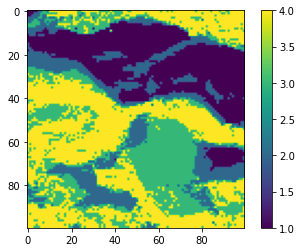

In [3]:
# the reference geology
plt.imshow(img_ref)
plt.colorbar()

In [4]:
def normed(x, xmax, xmin):
    return (x-xmin)/(xmax-xmin)
    

In [5]:
def backnormed(x, xmax, xmin):
    return x*(xmax-xmin)+xmin

In [6]:
def img_to_k(img):
    k = np.array(img, dtype='float32', copy=True)
    k[k==4] = 1e-1
    k[k==3] = 1e-3
    k[k==2] = 1e-4
    k[k==1] = 1e-5
    #return normed(k, 1e-1, 1e-5)
    return k

def img_to_porosity(img):
    porosity = np.array(img, dtype='float32', copy=True)
    porosity[porosity==4] = 0.25
    porosity[porosity==3] = 0.30
    porosity[porosity==2] = 0.35
    porosity[porosity==1] = 0.40
    #return normed(porosity, 0.4, 0.25)
    return porosity

def img_to_specificstorage(img):
    ss = np.array(img, dtype='float32', copy=True)
    ss[ss==4] = 1e-5
    ss[ss==3] = 1e-4
    ss[ss==2] = 5e-4
    ss[ss==1] = 1e-3
    return normed(ss, 1e-3, 1e-5)

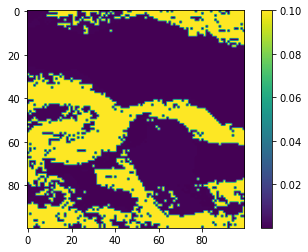

In [7]:
plt.imshow(img_to_k(img_ref))
plt.colorbar()

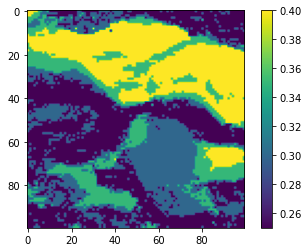

In [8]:
plt.imshow(img_to_porosity(img_ref))
plt.colorbar()

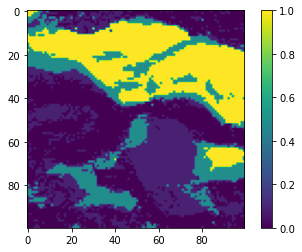

In [9]:
plt.imshow(img_to_specificstorage(img_ref))
plt.colorbar()

In [10]:
with open('ref/measurement-4.pickle', 'rb') as file_handle:
    concentrations_ref = pickle.load(file_handle)

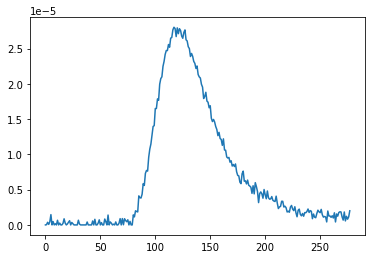

In [11]:
# the reference concentration curve
plt.plot(concentrations_ref[:])

For computation of the likelihood only 6 values sampled from the concentration cruve are used.
They are sampled at the following indexes:

In [12]:
ind = [50, 100, 125, 150, 200, 250]

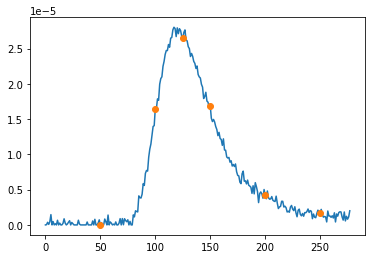

In [13]:
# the reference concentration curve
plt.plot(concentrations_ref[:])
plt.plot(ind, concentrations_ref[ind], 'o')

We can either use ML to estimate the mismatch directly, or try to estimate the 6 values on the concentration curve, or output YES/NO if mismatch is among 100 best.

I propose the following approach: use conductivity, porosity and specific storage. It results in (100,100,3) array for each model, filled with positive values. Normalize them. Then train a ML classifier on yes/no whether the model is among the 10% best in terms of likelihood.

## The dataset

In [14]:
N_POPEX = 500
# helper popex object
with open(f'popex-{N_POPEX}/popex.pop', 'rb') as file_handle:
    popex_object = pickle.load(file_handle)

In [15]:
def get_pickle(name):
    result = None
    try:
        with open(name, 'rb') as file_handle:
            result = pickle.load(file_handle)
    except FileNotFoundError as e:
        print(f'{name} failed: {str(e)}')
    return result

In [16]:
def get_vx(heads):
    vx = (heads[2:,:] - heads[:-2,:]) / 2
    return vx[:,1:-1]

def get_vy(heads):
    vy = (heads[:,2:] - heads[:,:-2]) / 2
    return vy[1:-1,:]

def get_red_porosity(porosity):
    return porosity[1:-1, 1:-1]

In [17]:
def _compute_heads(img, name, popex_dir, write_pickle=True):
    steady_state = tracer.TracerTest(cell_divisions=1, working_dir='modflow-steady-500')
    steady_state.run_steady(img, name=name)
    heads = steady_state.get_heads(name=name)
    if write_pickle:
        with open(_heads_file(name, popex_dir=popex_dir), 'wb') as file_handle:
            pickle.dump(heads, file_handle)
    steady_state.remove_modflow_workspace(name=name)
    return heads

def _compute_heads_from_tuple(img_tuple, popex_dir):
    for i,img in enumerate(img_tuple):
        name = f'{i}'
        _compute_heads(img, name, popex_dir)
        

def _heads_file(name, popex_dir):
    return f'heads-500/heads-{name}.pickle'

In [18]:
# load "good" concentrations
concentration_tuple = tuple(get_pickle(f'concentrations-{N_POPEX}/flow-{i}-concentration.pickle') for i in range(N_POPEX))
model_tuple = tuple(get_pickle(f'popex-{N_POPEX}/{i}') for i in popex_object.model[:N_POPEX])
img_tuple = tuple(i[0].param_val.reshape((100,100)) for i in model_tuple)

In [19]:
try:
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))
except TypeError:
    _compute_heads_from_tuple(img_tuple, 'popex-500')
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))

In [20]:
porosity_tuple = tuple(img_to_porosity(img) for img in img_tuple)
k_tuple = tuple(img_to_k(img) for img in img_tuple)
ss_tuple = tuple(img_to_specificstorage(img) for img in img_tuple)
red_porosity_tuple = tuple(get_red_porosity(porosity) for porosity in porosity_tuple)
red_k_tuple = tuple(get_red_porosity(k) for k in k_tuple)
vx_tuple = tuple(get_vx(heads) for heads in heads_transformed_tuple)
vy_tuple = tuple(get_vy(heads) for heads in heads_transformed_tuple)

vxp_tuple = tuple(vx*k/p for vx, p, k in zip(vx_tuple, red_porosity_tuple, red_k_tuple))
vyp_tuple = tuple(vy*k/p for vy, p, k in zip(vy_tuple, red_porosity_tuple, red_k_tuple))

The input data is in img_tuple (500 examples). The full output (concentraion curves) is in concentration_tuple

In [21]:
def norm_tuple(i_tuple):
    min_val = np.min(np.array(i_tuple))
    max_val = np.max(np.array(i_tuple))
    return tuple(normed(x, max_val, min_val) for x in i_tuple)

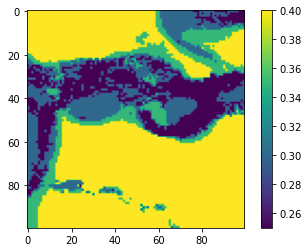

In [22]:
# example input porosity
plt.imshow(porosity_tuple[10])
plt.colorbar()

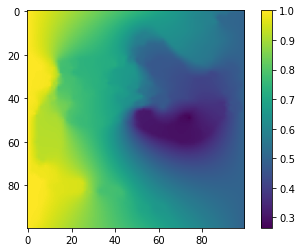

In [23]:
plt.imshow(heads_transformed_tuple[10])
plt.colorbar()

In [24]:
sorter = np.argsort(-popex_object.log_p_lik)

### Convert input to physical features and sample from output

In [247]:
# 500 samples 100x100 each with 2 channels
#X = np.stack([ np.stack([p, h], axis=2) for p,h in zip(porosity_tuple, heads_transformed_tuple) ])
#X = np.stack([ np.stack([p, k, ss], axis=2) for p,k,ss in zip(porosity_tuple, k_tuple, ss_tuple) ])
#X = np.stack([ np.stack([p, vx, vy], axis=2) for p,vx,vy in zip(red_porosity_tuple, vx_tuple, vy_tuple) ])
#X = np.stack([ np.stack([vx, vy, vxp, vyp], axis=2) for vx,vy,vxp,vyp in zip(vxp_tuple, vyp_tuple, vx_tuple, vy_tuple) ])
X = np.stack([ np.stack([vx, vy], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
#X = np.stack([ np.stack([vx**2 + vy**2], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
#X = np.stack([ np.stack([vx], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
X = np.stack([ np.stack([img], axis=2) for img in img_tuple ])
X.shape

(500, 100, 100, 1)

In [248]:
y = np.zeros((N_POPEX,))
y[sorter[:200]] = 1
y.shape

(500,)

In [249]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, shuffle=True)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y, shuffle=True)

In [253]:
X_flat, y_flat = X.reshape(X.shape[0], X.shape[-1]*X.shape[1]*X.shape[2]), y.reshape(y.shape[0])

In [254]:
X_train_flat = X_train.reshape(X_train.shape[0], X.shape[-1]*X.shape[1]*X.shape[2])
y_train_flat = y_train.reshape(y_train.shape[0])

X_test_flat = X_test.reshape(X_test.shape[0], X.shape[-1]*X.shape[1]*X.shape[2])
y_test_flat = y_test.reshape(y_test.shape[0])

In [255]:
X_flat.shape

(500, 10000)

## Simple sklearn classifiers

In [238]:
kfold = StratifiedKFold(random_state=1430, shuffle=True, n_splits=5)

In [239]:
classifiers = [
    LogisticRegression(max_iter=10000, class_weight='balanced'),
    AdaBoostClassifier(random_state=123, learning_rate=0.1, n_estimators=50),
    #AdaBoostClassifier(n_estimators=150),
    # t=0.4 actually can try for both
    RandomForestClassifier(class_weight='balanced', random_state=1234, n_estimators=1000, max_samples=0.4),
    #t=0.2
    #RandomForestClassifier(class_weight='balanced', random_state=1234, n_estimators=1000, max_samples=0.5),
    #RandomForestClassifier(n_estimators=1000, class_weight='balanced', criterion='entropy'),
]

In [240]:
#Intel(R) Xeon(R) CPU D-1541 @ 2.10GHz
cm = 3.8e2
cg = 1.05e4

In [241]:
alpha = 0.036
p = 200/500

In [242]:
from sklearn.metrics import fbeta_score, make_scorer
speed_scorer = make_scorer(fbeta_score, beta=alpha/p)

In [243]:
sqrt_5 = np.sqrt(5)

In [244]:
for classifier in classifiers:
    print(str(classifier))
    score = cross_validate(classifier, X_flat, y_flat, cv=kfold, scoring={'balanced_accuracy': 'balanced_accuracy', 'precision':'precision', 'speed_scorer':speed_scorer, 'recall': 'recall'})
    print(f'Mean precision: {np.mean(score["test_precision"])} +- {np.std(score["test_precision"])/sqrt_5}')
    print(f'Mean acc: {np.mean(score["test_balanced_accuracy"])} +- {np.std(score["test_balanced_accuracy"])/sqrt_5}')
    print(f'Mean recall: {np.mean(score["test_recall"])} +- {np.std(score["test_recall"])/sqrt_5}')
    print(f'Mean speed approx: {np.mean(score["test_precision"])/p} +- {np.std(score["test_precision"])/sqrt_5}')
    print(f'Mean speed: {np.mean(score["test_speed_scorer"])*(1+alpha)/(p+alpha)} +- {np.std(score["test_speed_scorer"])*(1+alpha)/(p+alpha)/sqrt_5}')
    #classifier = classifier.fit(X_train_flat, y_train_flat)
    #disp = metrics.plot_confusion_matrix(classifier, X_test_flat, y_test_flat)
    #plt.show()

LogisticRegression(class_weight='balanced', max_iter=10000)
Mean precision: 0.6770502780611094 +- 0.017786771415268878
Mean acc: 0.8016666666666665 +- 0.010710846008706419
Mean recall: 0.89 +- 0.015165750888103116
Mean speed approx: 1.6926256951527734 +- 0.017786771415268878
Mean speed: 1.6118054274608598 +- 0.04201390468053607
AdaBoostClassifier(learning_rate=0.1, random_state=123)
Mean precision: 0.8242379024484288 +- 0.010904266955832019
Mean acc: 0.8550000000000001 +- 0.012769320872918623
Mean recall: 0.8300000000000001 +- 0.03701351104664349
Mean speed approx: 2.0605947561210716 +- 0.010904266955832019
Mean speed: 1.958405934988794 +- 0.025345488977130286
RandomForestClassifier(class_weight='balanced', max_samples=0.4,
                       n_estimators=1000, random_state=1234)
Mean precision: 0.8492595226805753 +- 0.008341417989842207
Mean acc: 0.8541666666666667 +- 0.011303883305208786
Mean recall: 0.8049999999999999 +- 0.031937438845342635
Mean speed approx: 2.123148806701438 

In [155]:
speedup(precision=0.849, recall=0.804, c=0.036, t=p)

2.008068558966845

In [153]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=1234),
                          param_grid = {'n_estimators': [10, 100, 500, 1000, 2000],
                                       'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, None]},
                           return_train_score = True,
                           n_jobs=60,
                           cv = kfold,
                           scoring={'balanced_accuracy': 'balanced_accuracy',
                                    'precision':'precision',
                                    'speed_scorer':speed_scorer,
                                    'recall': 'recall'},
                           refit=False,
                          )

In [52]:
grid_search.fit(X_flat, y_flat)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1430, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1234),
             n_jobs=60,
             param_grid={'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                         0.9, None],
                         'n_estimators': [10, 100, 500, 1000, 2000]},
             refit=False, return_train_score=True,
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'precision': 'precision', 'recall': 'recall',
                      'speed_scorer': make_scorer(fbeta_score, beta=0.17999999999999997)})

In [53]:
import pandas as pd
df= pd.DataFrame(grid_search.cv_results_)
df.sort_values(by='mean_test_recall', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
49,25.859620,0.294777,0.129033,0.001543,None,2000,"{'max_samples': None, 'n_estimators': 2000}",0.60000,0.70000,0.60000,...,0.26,0.080000,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
32,4.806897,0.033552,0.037338,0.000362,0.7,500,"{'max_samples': 0.7, 'n_estimators': 500}",0.62500,0.70000,0.60000,...,0.26,0.073485,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
27,4.215823,0.091413,0.038019,0.000822,0.6,500,"{'max_samples': 0.6, 'n_estimators': 500}",0.60000,0.70000,0.59375,...,0.25,0.077460,3,0.9875,1.0000,0.9875,1.0000,0.9875,0.9925,0.006124
26,0.869026,0.027864,0.011940,0.000546,0.6,100,"{'max_samples': 0.6, 'n_estimators': 100}",0.62500,0.67500,0.59375,...,0.25,0.094868,3,0.9500,0.9750,0.9875,0.9875,0.9625,0.9725,0.014577
35,0.137390,0.005188,0.006013,0.000567,0.8,10,"{'max_samples': 0.8, 'n_estimators': 10}",0.61250,0.69375,0.51875,...,0.25,0.137840,3,0.8750,0.8875,0.8750,0.9000,0.8875,0.8850,0.009354
36,1.138704,0.021717,0.011775,0.000320,0.8,100,"{'max_samples': 0.8, 'n_estimators': 100}",0.65000,0.67500,0.59375,...,0.25,0.089443,6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
45,0.158539,0.006210,0.005674,0.000169,None,10,"{'max_samples': None, 'n_estimators': 10}",0.65000,0.63125,0.58125,...,0.24,0.073485,7,0.9375,0.9125,0.9250,0.9625,0.9500,0.9375,0.017678
34,19.183062,0.403504,0.127323,0.000970,0.7,2000,"{'max_samples': 0.7, 'n_estimators': 2000}",0.60000,0.70000,0.60000,...,0.24,0.080000,7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
43,12.022089,0.101903,0.067379,0.000981,0.9,1000,"{'max_samples': 0.9, 'n_estimators': 1000}",0.62500,0.67500,0.59375,...,0.23,0.067823,9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
42,6.232778,0.121044,0.037994,0.001001,0.9,500,"{'max_samples': 0.9, 'n_estimators': 500}",0.62500,0.67500,0.59375,...,0.23,0.067823,9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000


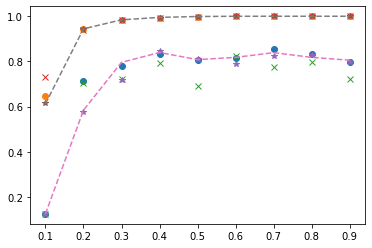

In [54]:
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_test_speed_scorer'], 'o')
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_train_speed_scorer'], 'o')

plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_test_speed_scorer'], 'x')
plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_train_speed_scorer'], 'x')

plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_test_speed_scorer'], '*')
plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_train_speed_scorer'], '*')

plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_test_speed_scorer'], '--')
plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_train_speed_scorer'], '--')

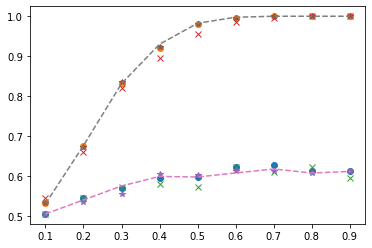

In [55]:
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_test_balanced_accuracy'], 'o')
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_train_balanced_accuracy'], 'o')

plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_test_balanced_accuracy'], 'x')
plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_train_balanced_accuracy'], 'x')

plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_test_balanced_accuracy'], '*')
plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_train_balanced_accuracy'], '*')

plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_test_balanced_accuracy'], '--')
plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_train_balanced_accuracy'], '--')

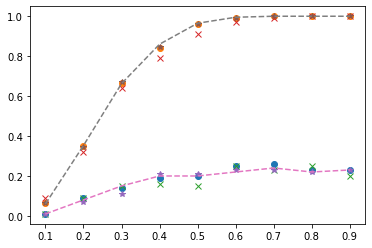

In [56]:
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_test_recall'], 'o')
plt.plot(df[df['param_n_estimators']==500]['param_max_samples'], df[df['param_n_estimators']==500]['mean_train_recall'], 'o')

plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_test_recall'], 'x')
plt.plot(df[df['param_n_estimators']==100]['param_max_samples'], df[df['param_n_estimators']==100]['mean_train_recall'], 'x')

plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_test_recall'], '*')
plt.plot(df[df['param_n_estimators']==1000]['param_max_samples'], df[df['param_n_estimators']==1000]['mean_train_recall'], '*')

plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_test_recall'], '--')
plt.plot(df[df['param_n_estimators']==2000]['param_max_samples'], df[df['param_n_estimators']==2000]['mean_train_recall'], '--')

In [57]:
grid_search_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=123),
                          param_grid = {'n_estimators': [10, 20, 30, 40, 50, 100],
                                       'learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]},
                           return_train_score = True,
                           n_jobs=36,
                           cv = kfold,
                           scoring={'balanced_accuracy': 'balanced_accuracy',
                                    'precision':'precision',
                                    'speed_scorer':speed_scorer,
                                    'recall': 'recall'},
                           refit=False,
                          )

In [58]:
grid_search_ada.fit(X_flat, y_flat)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1430, shuffle=True),
             estimator=AdaBoostClassifier(random_state=123), n_jobs=36,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 30, 40, 50, 100]},
             refit=False, return_train_score=True,
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'precision': 'precision', 'recall': 'recall',
                      'speed_scorer': make_scorer(fbeta_score, beta=0.17999999999999997)})

In [59]:
df_ada= pd.DataFrame(grid_search_ada.cv_results_)
df_ada.sort_values(by='mean_test_recall', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
35,62.747269,0.954565,0.223802,0.023495,1,100,"{'learning_rate': 1.0, 'n_estimators': 100}",0.80625,0.85000,0.79375,...,0.63,0.128841,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
33,25.876583,0.297569,0.104816,0.006312,1,40,"{'learning_rate': 1.0, 'n_estimators': 40}",0.77500,0.81250,0.71875,...,0.62,0.081240,2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
32,19.332552,0.253875,0.082444,0.010803,1,30,"{'learning_rate': 1.0, 'n_estimators': 30}",0.77500,0.78750,0.73750,...,0.60,0.063246,3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
30,6.556750,0.040668,0.028974,0.000667,1,10,"{'learning_rate': 1.0, 'n_estimators': 10}",0.70625,0.86250,0.72500,...,0.59,0.115758,4,0.7875,0.8000,0.8375,0.9000,0.8875,0.8425,0.045139
34,32.540333,0.174453,0.127560,0.008919,1,50,"{'learning_rate': 1.0, 'n_estimators': 50}",0.75000,0.79375,0.73750,...,0.58,0.097980,5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
29,64.716798,0.331249,0.240560,0.017698,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.76875,0.78750,0.77500,...,0.58,0.097980,5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
31,13.071081,0.324727,0.051903,0.003784,1,20,"{'learning_rate': 1.0, 'n_estimators': 20}",0.73750,0.76875,0.76250,...,0.56,0.058310,7,0.9875,1.0000,0.9875,1.0000,0.9875,0.9925,0.006124
28,32.285470,0.210965,0.118249,0.006469,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.78125,0.76250,0.74375,...,0.56,0.101980,7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
27,25.603713,0.304553,0.095332,0.009173,0.5,40,"{'learning_rate': 0.5, 'n_estimators': 40}",0.72500,0.76250,0.75625,...,0.55,0.063246,9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000
21,25.842830,0.370980,0.104909,0.012559,0.25,40,"{'learning_rate': 0.25, 'n_estimators': 40}",0.78750,0.75000,0.68125,...,0.55,0.070711,9,0.9750,1.0000,0.9875,0.9875,0.9750,0.9850,0.009354


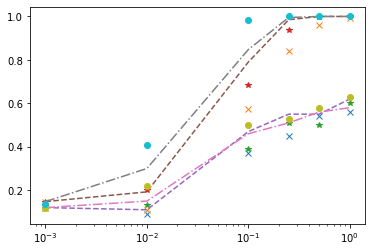

In [60]:
df = df_ada
#plt.semilogx(df[df['param_n_estimators']==10]['param_learning_rate'], df[df['param_n_estimators']==10]['mean_test_recall'], 'o')
#plt.semilogx(df[df['param_n_estimators']==10]['param_learning_rate'], df[df['param_n_estimators']==10]['mean_train_recall'], 'o')

plt.semilogx(df[df['param_n_estimators']==20]['param_learning_rate'], df[df['param_n_estimators']==20]['mean_test_recall'], 'x')
plt.semilogx(df[df['param_n_estimators']==20]['param_learning_rate'], df[df['param_n_estimators']==20]['mean_train_recall'], 'x')

plt.semilogx(df[df['param_n_estimators']==30]['param_learning_rate'], df[df['param_n_estimators']==30]['mean_test_recall'], '*')
plt.semilogx(df[df['param_n_estimators']==30]['param_learning_rate'], df[df['param_n_estimators']==30]['mean_train_recall'], '*')

plt.semilogx(df[df['param_n_estimators']==40]['param_learning_rate'], df[df['param_n_estimators']==40]['mean_test_recall'], '--')
plt.semilogx(df[df['param_n_estimators']==40]['param_learning_rate'], df[df['param_n_estimators']==40]['mean_train_recall'], '--')

plt.semilogx(df[df['param_n_estimators']==50]['param_learning_rate'], df[df['param_n_estimators']==50]['mean_test_recall'], '-.')
plt.semilogx(df[df['param_n_estimators']==50]['param_learning_rate'], df[df['param_n_estimators']==50]['mean_train_recall'], '-.')

plt.semilogx(df[df['param_n_estimators']==100]['param_learning_rate'], df[df['param_n_estimators']==100]['mean_test_recall'], 'o')
plt.semilogx(df[df['param_n_estimators']==100]['param_learning_rate'], df[df['param_n_estimators']==100]['mean_train_recall'], 'o')

## CNN 

https://keras.io/examples/vision/mnist_convnet/

In [33]:
#X = X[:,35:65,20:80:]

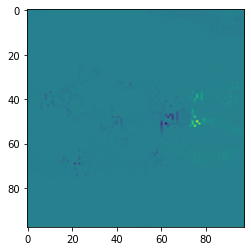

In [51]:
plt.imshow(X[0,:,:,1])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=431, stratify=y, shuffle=True)

In [53]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #keras.layers.Convolution2D(32, kernel_size=(3, 3), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #keras.layers.Convolution2D(32, kernel_size=(3, 3), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [54]:
384/4

96.0

In [178]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(24, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(64, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [179]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_234 (Conv2D)          (None, 47, 47, 24)        1224      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 19, 19, 64)        38464     
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 7, 7, 96)          55392     
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 5, 5, 96)          83040     
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 3, 3, 64)        

In [180]:
p = 0.4
weights = {0:p, 1:1-p}
def train_test_modelCNN(model, X_train, y_train, X_test, y_test, epochs, learning_rate=0.01, verbose=1):
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'],
                  weighted_metrics=['accuracy'])
    return model.fit(X_train, y_train, batch_size=len(X), epochs=epochs, verbose=verbose, validation_data=(X_test, y_test), class_weight=weights)

In [181]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 0s 415ms/step - loss: 0.3327 - precision_53: 0.5421 - recall_53: 0.6438 - accuracy: 0.6400 - weighted_accuracy: 0.6406 - val_loss: 0.6933 - val_precision_53: 0.4040 - val_recall_53: 1.0000 - val_accuracy: 0.4100 - val_weighted_accuracy: 0.4100
Epoch 2/500
1/1 [==============================] - 0s 60ms/step - loss: 0.3327 - precision_53: 0.4010 - recall_53: 1.0000 - accuracy: 0.4025 - weighted_accuracy: 0.5021 - val_loss: 0.6929 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 3/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3327 - precision_53: 0.0000e+00 - recall_53: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6928 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/500
1/1 [==============================] - 0s 79ms/step - loss: 0.3326 - precision_53

Epoch 56/500
1/1 [==============================] - 0s 101ms/step - loss: 0.3084 - precision_53: 0.4984 - recall_53: 0.9937 - accuracy: 0.5975 - weighted_accuracy: 0.6635 - val_loss: 0.6696 - val_precision_53: 0.5763 - val_recall_53: 0.8500 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 57/500
1/1 [==============================] - 0s 54ms/step - loss: 0.2195 - precision_53: 0.6144 - recall_53: 0.9062 - accuracy: 0.7350 - weighted_accuracy: 0.7635 - val_loss: 1.0562 - val_precision_53: 0.8000 - val_recall_53: 0.1000 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 58/500
1/1 [==============================] - 0s 54ms/step - loss: 0.4299 - precision_53: 0.7500 - recall_53: 0.1125 - accuracy: 0.6300 - weighted_accuracy: 0.5437 - val_loss: 0.7948 - val_precision_53: 0.5139 - val_recall_53: 0.9250 - val_accuracy: 0.6200 - val_weighted_accuracy: 0.6200
Epoch 59/500
1/1 [==============================] - 0s 47ms/step - loss: 0.2914 - precision_53: 0.5113 - recall_53

Epoch 84/500
1/1 [==============================] - 0s 77ms/step - loss: 0.2144 - precision_53: 0.6733 - recall_53: 0.8500 - accuracy: 0.7750 - weighted_accuracy: 0.7875 - val_loss: 0.6080 - val_precision_53: 0.6538 - val_recall_53: 0.8500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 85/500
1/1 [==============================] - 0s 74ms/step - loss: 0.2110 - precision_53: 0.6683 - recall_53: 0.8687 - accuracy: 0.7750 - weighted_accuracy: 0.7906 - val_loss: 0.6213 - val_precision_53: 0.7222 - val_recall_53: 0.6500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 86/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2204 - precision_53: 0.7333 - recall_53: 0.7563 - accuracy: 0.7925 - weighted_accuracy: 0.7865 - val_loss: 0.9659 - val_precision_53: 0.5000 - val_recall_53: 0.9250 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 87/500
1/1 [==============================] - 0s 77ms/step - loss: 0.3374 - precision_53: 0.5113 - recall_53:

Epoch 112/500
1/1 [==============================] - 0s 73ms/step - loss: 0.1945 - precision_53: 0.6842 - recall_53: 0.8938 - accuracy: 0.7925 - weighted_accuracy: 0.8094 - val_loss: 0.6268 - val_precision_53: 0.6809 - val_recall_53: 0.8000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 113/500
1/1 [==============================] - 0s 70ms/step - loss: 0.1923 - precision_53: 0.6842 - recall_53: 0.8938 - accuracy: 0.7925 - weighted_accuracy: 0.8094 - val_loss: 0.6111 - val_precision_53: 0.6977 - val_recall_53: 0.7500 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 114/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1881 - precision_53: 0.7079 - recall_53: 0.8938 - accuracy: 0.8100 - weighted_accuracy: 0.8240 - val_loss: 0.6011 - val_precision_53: 0.7073 - val_recall_53: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 115/500
1/1 [==============================] - 0s 74ms/step - loss: 0.1857 - precision_53: 0.7302 - recall

Epoch 140/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1476 - precision_53: 0.7343 - recall_53: 0.9500 - accuracy: 0.8425 - weighted_accuracy: 0.8604 - val_loss: 0.7590 - val_precision_53: 0.6739 - val_recall_53: 0.7750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 141/500
1/1 [==============================] - 0s 93ms/step - loss: 0.1442 - precision_53: 0.7488 - recall_53: 0.9500 - accuracy: 0.8525 - weighted_accuracy: 0.8687 - val_loss: 0.7923 - val_precision_53: 0.7500 - val_recall_53: 0.7500 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 142/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1408 - precision_53: 0.8066 - recall_53: 0.9125 - accuracy: 0.8775 - weighted_accuracy: 0.8833 - val_loss: 0.8210 - val_precision_53: 0.8333 - val_recall_53: 0.7500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 143/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1422 - precision_53: 0.8198 - recall

Epoch 168/500
1/1 [==============================] - 0s 71ms/step - loss: 0.1045 - precision_53: 0.8297 - recall_53: 0.9438 - accuracy: 0.9000 - weighted_accuracy: 0.9073 - val_loss: 1.2650 - val_precision_53: 0.7105 - val_recall_53: 0.6750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 169/500
1/1 [==============================] - 0s 78ms/step - loss: 0.1075 - precision_53: 0.8506 - recall_53: 0.9250 - accuracy: 0.9050 - weighted_accuracy: 0.9083 - val_loss: 1.1796 - val_precision_53: 0.6275 - val_recall_53: 0.8000 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 170/500
1/1 [==============================] - 0s 64ms/step - loss: 0.1078 - precision_53: 0.8154 - recall_53: 0.9937 - accuracy: 0.9075 - weighted_accuracy: 0.9219 - val_loss: 1.1914 - val_precision_53: 0.6200 - val_recall_53: 0.7750 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 171/500
1/1 [==============================] - 0s 65ms/step - loss: 0.1038 - precision_53: 0.8177 - recall

Epoch 196/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0878 - precision_53: 0.8970 - recall_53: 0.9250 - accuracy: 0.9275 - weighted_accuracy: 0.9271 - val_loss: 1.4685 - val_precision_53: 0.6154 - val_recall_53: 0.8000 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 197/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0947 - precision_53: 0.8040 - recall_53: 1.0000 - accuracy: 0.9025 - weighted_accuracy: 0.9187 - val_loss: 1.5017 - val_precision_53: 0.6327 - val_recall_53: 0.7750 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 198/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0866 - precision_53: 0.8333 - recall_53: 1.0000 - accuracy: 0.9200 - weighted_accuracy: 0.9333 - val_loss: 1.7605 - val_precision_53: 0.7059 - val_recall_53: 0.6000 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 199/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0891 - precision_53: 0.8944 - recall

Epoch 224/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0643 - precision_53: 0.9070 - recall_53: 0.9750 - accuracy: 0.9500 - weighted_accuracy: 0.9542 - val_loss: 1.4966 - val_precision_53: 0.7143 - val_recall_53: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 225/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0636 - precision_53: 0.9172 - recall_53: 0.9688 - accuracy: 0.9525 - weighted_accuracy: 0.9552 - val_loss: 1.3373 - val_precision_53: 0.7143 - val_recall_53: 0.7500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 226/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0590 - precision_53: 0.8939 - recall_53: 1.0000 - accuracy: 0.9525 - weighted_accuracy: 0.9604 - val_loss: 1.3945 - val_precision_53: 0.6977 - val_recall_53: 0.7500 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 227/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0594 - precision_53: 0.8889 - recall

Epoch 252/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0378 - precision_53: 0.9461 - recall_53: 0.9875 - accuracy: 0.9725 - weighted_accuracy: 0.9750 - val_loss: 1.6818 - val_precision_53: 0.6591 - val_recall_53: 0.7250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 253/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0392 - precision_53: 0.9195 - recall_53: 1.0000 - accuracy: 0.9650 - weighted_accuracy: 0.9708 - val_loss: 1.8366 - val_precision_53: 0.6923 - val_recall_53: 0.6750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 254/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0345 - precision_53: 0.9357 - recall_53: 1.0000 - accuracy: 0.9725 - weighted_accuracy: 0.9771 - val_loss: 2.1014 - val_precision_53: 0.6857 - val_recall_53: 0.6000 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 255/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0404 - precision_53: 0.9512 - recall

Epoch 280/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1640 - precision_53: 0.7594 - recall_53: 0.8875 - accuracy: 0.8425 - weighted_accuracy: 0.8500 - val_loss: 1.5645 - val_precision_53: 0.7632 - val_recall_53: 0.7250 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 281/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1647 - precision_53: 0.7705 - recall_53: 0.8813 - accuracy: 0.8475 - weighted_accuracy: 0.8531 - val_loss: 1.5226 - val_precision_53: 0.6600 - val_recall_53: 0.8250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 282/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1595 - precision_53: 0.7400 - recall_53: 0.9250 - accuracy: 0.8400 - weighted_accuracy: 0.8542 - val_loss: 1.5044 - val_precision_53: 0.6415 - val_recall_53: 0.8500 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 283/500
1/1 [==============================] - 0s 66ms/step - loss: 0.1616 - precision_53: 0.7150 - recall

Epoch 308/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1230 - precision_53: 0.7957 - recall_53: 0.9250 - accuracy: 0.8750 - weighted_accuracy: 0.8833 - val_loss: 1.8074 - val_precision_53: 0.6739 - val_recall_53: 0.7750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 309/500
1/1 [==============================] - 0s 42ms/step - loss: 0.1222 - precision_53: 0.7947 - recall_53: 0.9438 - accuracy: 0.8800 - weighted_accuracy: 0.8906 - val_loss: 1.8264 - val_precision_53: 0.7143 - val_recall_53: 0.7500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 310/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1210 - precision_53: 0.8343 - recall_53: 0.9125 - accuracy: 0.8925 - weighted_accuracy: 0.8958 - val_loss: 1.8400 - val_precision_53: 0.6739 - val_recall_53: 0.7750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 311/500
1/1 [==============================] - 0s 66ms/step - loss: 0.1194 - precision_53: 0.7958 - recall

Epoch 336/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1063 - precision_53: 0.8343 - recall_53: 0.9438 - accuracy: 0.9025 - weighted_accuracy: 0.9094 - val_loss: 2.2590 - val_precision_53: 0.6275 - val_recall_53: 0.8000 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 337/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1058 - precision_53: 0.8245 - recall_53: 0.9688 - accuracy: 0.9050 - weighted_accuracy: 0.9156 - val_loss: 2.2962 - val_precision_53: 0.6304 - val_recall_53: 0.7250 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 338/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1028 - precision_53: 0.8343 - recall_53: 0.9438 - accuracy: 0.9025 - weighted_accuracy: 0.9094 - val_loss: 2.3439 - val_precision_53: 0.6667 - val_recall_53: 0.7000 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 339/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1035 - precision_53: 0.8613 - recall

Epoch 364/500
1/1 [==============================] - 0s 96ms/step - loss: 0.0716 - precision_53: 0.8870 - recall_53: 0.9812 - accuracy: 0.9425 - weighted_accuracy: 0.9490 - val_loss: 2.7990 - val_precision_53: 0.6750 - val_recall_53: 0.6750 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 365/500
1/1 [==============================] - 0s 105ms/step - loss: 0.0705 - precision_53: 0.8920 - recall_53: 0.9812 - accuracy: 0.9450 - weighted_accuracy: 0.9510 - val_loss: 2.8220 - val_precision_53: 0.6829 - val_recall_53: 0.7000 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 366/500
1/1 [==============================] - 0s 115ms/step - loss: 0.0693 - precision_53: 0.8870 - recall_53: 0.9812 - accuracy: 0.9425 - weighted_accuracy: 0.9490 - val_loss: 2.8527 - val_precision_53: 0.6750 - val_recall_53: 0.6750 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 367/500
1/1 [==============================] - 0s 88ms/step - loss: 0.0682 - precision_53: 0.8920 - reca

Epoch 392/500
1/1 [==============================] - 0s 130ms/step - loss: 0.0911 - precision_53: 0.8525 - recall_53: 0.9750 - accuracy: 0.9225 - weighted_accuracy: 0.9312 - val_loss: 2.4383 - val_precision_53: 0.6531 - val_recall_53: 0.8000 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 393/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0937 - precision_53: 0.8387 - recall_53: 0.9750 - accuracy: 0.9150 - weighted_accuracy: 0.9250 - val_loss: 2.4994 - val_precision_53: 0.6809 - val_recall_53: 0.8000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 394/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0955 - precision_53: 0.8424 - recall_53: 0.9688 - accuracy: 0.9150 - weighted_accuracy: 0.9240 - val_loss: 2.5532 - val_precision_53: 0.6739 - val_recall_53: 0.7750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 395/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0939 - precision_53: 0.8556 - recal

Epoch 420/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0522 - precision_53: 0.9244 - recall_53: 0.9937 - accuracy: 0.9650 - weighted_accuracy: 0.9698 - val_loss: 3.0736 - val_precision_53: 0.6667 - val_recall_53: 0.6500 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 421/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0518 - precision_53: 0.9244 - recall_53: 0.9937 - accuracy: 0.9650 - weighted_accuracy: 0.9698 - val_loss: 3.1424 - val_precision_53: 0.6842 - val_recall_53: 0.6500 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 422/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0509 - precision_53: 0.9244 - recall_53: 0.9937 - accuracy: 0.9650 - weighted_accuracy: 0.9698 - val_loss: 3.1943 - val_precision_53: 0.6667 - val_recall_53: 0.6500 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 423/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0498 - precision_53: 0.9298 - recall

Epoch 448/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0354 - precision_53: 0.9412 - recall_53: 1.0000 - accuracy: 0.9750 - weighted_accuracy: 0.9792 - val_loss: 3.9726 - val_precision_53: 0.6923 - val_recall_53: 0.6750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 449/500
1/1 [==============================] - 0s 122ms/step - loss: 0.0349 - precision_53: 0.9412 - recall_53: 1.0000 - accuracy: 0.9750 - weighted_accuracy: 0.9792 - val_loss: 4.0032 - val_precision_53: 0.6750 - val_recall_53: 0.6750 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 450/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0345 - precision_53: 0.9467 - recall_53: 1.0000 - accuracy: 0.9775 - weighted_accuracy: 0.9812 - val_loss: 4.0598 - val_precision_53: 0.6923 - val_recall_53: 0.6750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 451/500
1/1 [==============================] - 0s 85ms/step - loss: 0.0340 - precision_53: 0.9467 - recal

Epoch 476/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0233 - precision_53: 0.9524 - recall_53: 1.0000 - accuracy: 0.9800 - weighted_accuracy: 0.9833 - val_loss: 4.8598 - val_precision_53: 0.7027 - val_recall_53: 0.6500 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 477/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0237 - precision_53: 0.9581 - recall_53: 1.0000 - accuracy: 0.9825 - weighted_accuracy: 0.9854 - val_loss: 4.8412 - val_precision_53: 0.7179 - val_recall_53: 0.7000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 478/500
1/1 [==============================] - 0s 85ms/step - loss: 0.0238 - precision_53: 0.9524 - recall_53: 1.0000 - accuracy: 0.9800 - weighted_accuracy: 0.9833 - val_loss: 4.9531 - val_precision_53: 0.7222 - val_recall_53: 0.6500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 479/500
1/1 [==============================] - 0s 90ms/step - loss: 0.0224 - precision_53: 0.9581 - recall

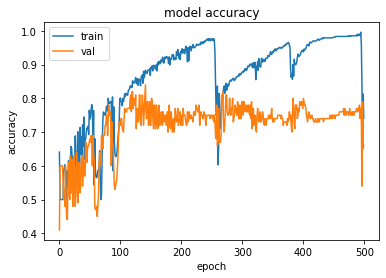

In [182]:
plt.plot(history.history['weighted_accuracy'])
plt.plot(history.history['val_weighted_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


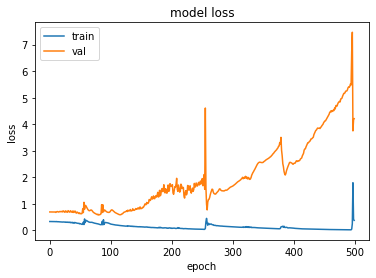

In [183]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [184]:
precision_scores = np.zeros(5)
recall_scores = np.zeros(5)
results = []
kfold = StratifiedKFold(random_state=44, shuffle=True, n_splits=5)
for i, (train, test) in enumerate(kfold.split(X_flat, y_flat)):
    model = None
    model = build_CNN_model()
    result = train_test_modelCNN(model, X[train], y[train], X[test], y[test], epochs=120, learning_rate=0.001, verbose=0,)
    results.append(result)
    score = model.evaluate(X[test], y[test])
    precision_scores[i] = score[1]
    recall_scores[i] = score[2]

4/4 [==============================] - 0s 13ms/step - loss: 0.5786 - precision_58: 0.8966 - recall_58: 0.6500 - accuracy: 0.8300 - weighted_accuracy: 0.8300


In [63]:
mean_loss = np.mean(np.stack([np.array(x.history['loss']) for x in results]), axis=0)

In [64]:
mean_loss_val = np.mean(np.stack([np.array(x.history['val_loss']) for x in results]), axis=0)

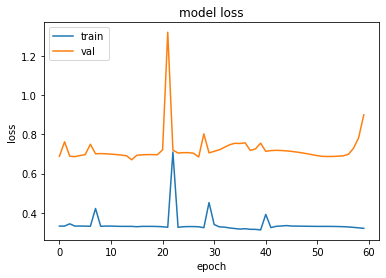

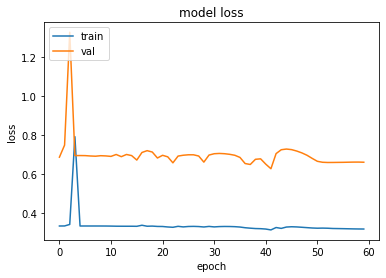

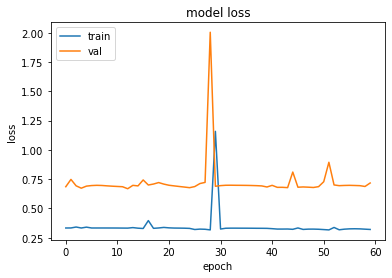

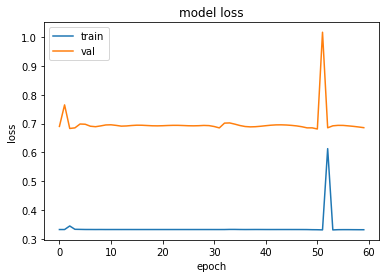

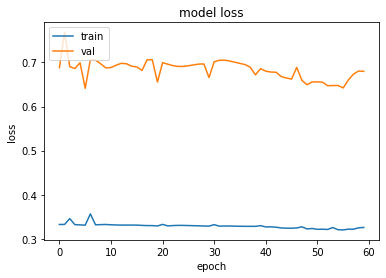

In [65]:
for x in results:
    plt.figure()
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [69]:
sqrt_5 = np.sqrt(5)

In [70]:
def speedup(precision, recall, c, t):
    return (1+c)/(c/recall+ t/precision)

In [185]:
#speed-up
speedup_scores = speedup(precision_scores, recall_scores, c=alpha, t=p)
np.mean(speedup_scores), np.std(speedup_scores)/sqrt_5

(1.7476744143501215, 0.07628726705478805)

In [186]:
#precision
np.mean(precision_scores), np.std(precision_scores)/sqrt_5

(0.7339408278465271, 0.03814579180679944)

In [187]:
#recall
np.mean(recall_scores), np.std(recall_scores)/sqrt_5

(0.7849999785423278, 0.036469165580624095)

## Simplify

In [76]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(24, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(64, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [77]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 47, 47, 24)        1224      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 19, 19, 64)        38464     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              5309440   
_________________________________________________________________
dense_31 (Dense)             (None, 1024)            

In [79]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 399ms/step - loss: 0.3327 - precision_7: 0.3918 - recall_7: 0.6000 - accuracy: 0.4675 - weighted_accuracy: 0.4896 - val_loss: 0.6808 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 2/200
1/1 [==============================] - 0s 75ms/step - loss: 0.3608 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.7095 - val_precision_7: 0.4000 - val_recall_7: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 70ms/step - loss: 0.3340 - precision_7: 0.4000 - recall_7: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 0.6855 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/200
1/1 [==============================] - 0s 110ms/step - loss: 0.3328 - precision_7: 0.0000e+00

Epoch 29/200
1/1 [==============================] - 0s 70ms/step - loss: 0.3145 - precision_7: 0.4409 - recall_7: 0.9563 - accuracy: 0.4975 - weighted_accuracy: 0.5740 - val_loss: 0.7361 - val_precision_7: 0.4186 - val_recall_7: 0.9000 - val_accuracy: 0.4600 - val_weighted_accuracy: 0.4600
Epoch 30/200
1/1 [==============================] - 0s 61ms/step - loss: 0.3176 - precision_7: 0.4333 - recall_7: 0.9750 - accuracy: 0.4800 - weighted_accuracy: 0.5625 - val_loss: 0.7824 - val_precision_7: 0.4138 - val_recall_7: 0.9000 - val_accuracy: 0.4500 - val_weighted_accuracy: 0.4500
Epoch 31/200
1/1 [==============================] - 0s 59ms/step - loss: 0.3189 - precision_7: 0.4262 - recall_7: 0.9750 - accuracy: 0.4650 - weighted_accuracy: 0.5500 - val_loss: 0.7831 - val_precision_7: 0.4157 - val_recall_7: 0.9250 - val_accuracy: 0.4500 - val_weighted_accuracy: 0.4500
Epoch 32/200
1/1 [==============================] - 0s 67ms/step - loss: 0.3189 - precision_7: 0.4286 - recall_7: 0.9750 - accu

1/1 [==============================] - 0s 88ms/step - loss: 0.2388 - precision_7: 0.6157 - recall_7: 0.8313 - accuracy: 0.7250 - weighted_accuracy: 0.7427 - val_loss: 1.7035 - val_precision_7: 0.5319 - val_recall_7: 0.6250 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 86/200
1/1 [==============================] - 0s 98ms/step - loss: 0.2378 - precision_7: 0.6244 - recall_7: 0.8000 - accuracy: 0.7275 - weighted_accuracy: 0.7396 - val_loss: 1.8131 - val_precision_7: 0.5000 - val_recall_7: 0.7000 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 87/200
1/1 [==============================] - 0s 90ms/step - loss: 0.2358 - precision_7: 0.6102 - recall_7: 0.9000 - accuracy: 0.7300 - weighted_accuracy: 0.7583 - val_loss: 1.9603 - val_precision_7: 0.5185 - val_recall_7: 0.7000 - val_accuracy: 0.6200 - val_weighted_accuracy: 0.6200
Epoch 88/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2303 - precision_7: 0.6290 - recall_7: 0.8687 - accuracy: 0.7425 

1/1 [==============================] - 0s 85ms/step - loss: 0.1208 - precision_7: 0.8802 - recall_7: 0.9187 - accuracy: 0.9175 - weighted_accuracy: 0.9177 - val_loss: 2.3738 - val_precision_7: 0.5098 - val_recall_7: 0.6500 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 142/200
1/1 [==============================] - 0s 118ms/step - loss: 0.1024 - precision_7: 0.8793 - recall_7: 0.9563 - accuracy: 0.9300 - weighted_accuracy: 0.9344 - val_loss: 2.3909 - val_precision_7: 0.4912 - val_recall_7: 0.7000 - val_accuracy: 0.5900 - val_weighted_accuracy: 0.5900
Epoch 143/200
1/1 [==============================] - 0s 74ms/step - loss: 0.1052 - precision_7: 0.8235 - recall_7: 0.9625 - accuracy: 0.9025 - weighted_accuracy: 0.9125 - val_loss: 2.6213 - val_precision_7: 0.4808 - val_recall_7: 0.6250 - val_accuracy: 0.5800 - val_weighted_accuracy: 0.5800
Epoch 144/200
1/1 [==============================] - 0s 66ms/step - loss: 0.1027 - precision_7: 0.8389 - recall_7: 0.9438 - accuracy: 0.9

1/1 [==============================] - 0s 84ms/step - loss: 0.0020 - precision_7: 1.0000 - recall_7: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.9305 - val_precision_7: 0.6500 - val_recall_7: 0.6500 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 198/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0018 - precision_7: 1.0000 - recall_7: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.9554 - val_precision_7: 0.6190 - val_recall_7: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 199/200
1/1 [==============================] - 0s 128ms/step - loss: 0.0016 - precision_7: 1.0000 - recall_7: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.9810 - val_precision_7: 0.6190 - val_recall_7: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 200/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0015 - precision_7: 1.0000 - recall_7: 1.0000 - accuracy: 1.0

In [80]:
def plot_accuracy(history):
    plt.plot(history.history['weighted_accuracy'])
    plt.plot(history.history['val_weighted_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

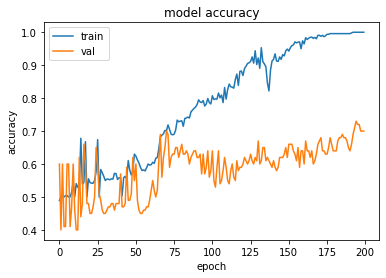

In [81]:
plot_accuracy(history)

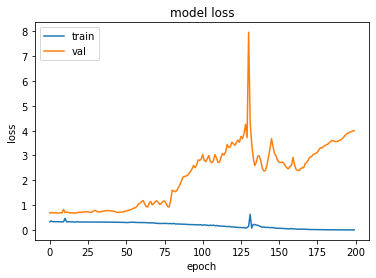

In [82]:
plot_loss(history)

In [162]:
def cross_validate_cnn(epochs, learning_rate=0.01):
    precision_scores = np.zeros(5)
    recall_scores = np.zeros(5)
    results = []
    kfold = StratifiedKFold(random_state=44, shuffle=True, n_splits=5)
    for i, (train, test) in enumerate(kfold.split(X_flat, y_flat)):
        model = None
        model = build_CNN_model()
        result = train_test_modelCNN(model, X[train], y[train], X[test], y[test], epochs=epochs,learning_rate=learning_rate,verbose=0,)
        results.append(result)
        score = model.evaluate(X[test], y[test])
        precision_scores[i] = score[1]
        recall_scores[i] = score[2]
    return precision_scores, recall_scores, results

In [102]:
precision_scores, recall_scores, results = cross_validate(epochs=50)

4/4 [==============================] - 0s 20ms/step - loss: 0.6161 - precision_25: 0.7436 - recall_25: 0.7250 - accuracy: 0.7900 - weighted_accuracy: 0.7900


In [103]:
def plot_losses(results):
    for x in results:
        plt.figure()
        plt.plot(x.history['loss'])
        plt.plot(x.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

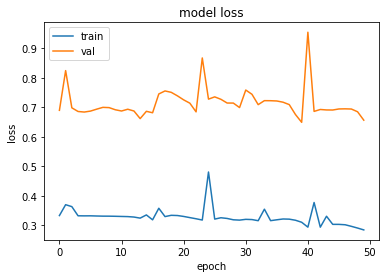

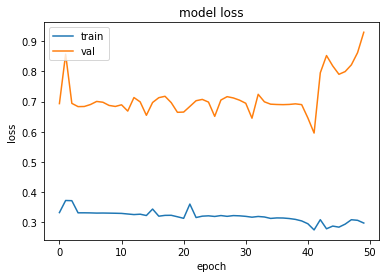

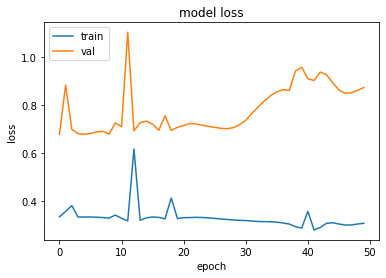

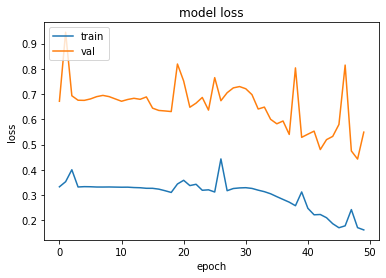

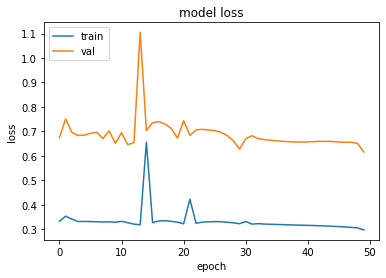

In [104]:
plot_losses(results)

In [105]:
def print_report(precision_scores, recall_scores):
    #speed-up
    speedup_scores = speedup(precision_scores, recall_scores, c=alpha, t=p)
    print(f"Speedup: {np.mean(speedup_scores)} +- {np.std(speedup_scores)/sqrt_5}")
    #precision
    print(f"Precision: {np.mean(precision_scores)} +- {np.std(precision_scores)/sqrt_5}")
    #recall
    print(f"Recall: {np.mean(recall_scores)} +- {np.std(recall_scores)/sqrt_5}")

In [106]:
print_report(precision_scores, recall_scores)

Speedup: 1.1286713845815441 +- 0.2728485784817773
Precision: 0.4667107880115509 +- 0.11446892085713893
Recall: 0.6500000119209289 +- 0.15182226811876284


## More simplify

In [107]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(24, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(64, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(96, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [108]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 47, 47, 24)        1224      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 23, 23, 24)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 12696)             0         
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              13001728  
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 1025      
Total params: 14,053,577
Trainable params: 14,053,577
Non-trainable params: 0
_________________________________________

In [109]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 327ms/step - loss: 0.3327 - precision_26: 0.3801 - recall_26: 0.4062 - accuracy: 0.4975 - weighted_accuracy: 0.4823 - val_loss: 0.6853 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 2/200
1/1 [==============================] - 1s 546ms/step - loss: 0.3661 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.8521 - val_precision_26: 0.4000 - val_recall_26: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 0.3702 - precision_26: 0.4000 - recall_26: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 0.6922 - val_precision_26: 0.3958 - val_recall_26: 0.9500 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 4/200
1/1 [==============================] - 0s 105ms/step - loss: 0.3320 - precision_26: 0.41

Epoch 56/200
1/1 [==============================] - 0s 94ms/step - loss: 0.2720 - precision_26: 0.5307 - recall_26: 0.9187 - accuracy: 0.6425 - weighted_accuracy: 0.6885 - val_loss: 0.7518 - val_precision_26: 0.6250 - val_recall_26: 0.7500 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 57/200
1/1 [==============================] - 0s 60ms/step - loss: 0.2313 - precision_26: 0.6465 - recall_26: 0.8687 - accuracy: 0.7575 - weighted_accuracy: 0.7760 - val_loss: 1.0739 - val_precision_26: 0.7333 - val_recall_26: 0.2750 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 58/200
1/1 [==============================] - 0s 75ms/step - loss: 0.3864 - precision_26: 0.8095 - recall_26: 0.4250 - accuracy: 0.7300 - weighted_accuracy: 0.6792 - val_loss: 0.8173 - val_precision_26: 0.5556 - val_recall_26: 0.8750 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 59/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2413 - precision_26: 0.5968 - recall_26:

Epoch 84/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2624 - precision_26: 0.5412 - recall_26: 0.9438 - accuracy: 0.6575 - weighted_accuracy: 0.7052 - val_loss: 1.1022 - val_precision_26: 0.4925 - val_recall_26: 0.8250 - val_accuracy: 0.5900 - val_weighted_accuracy: 0.5900
Epoch 85/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2596 - precision_26: 0.5329 - recall_26: 0.9625 - accuracy: 0.6475 - weighted_accuracy: 0.7000 - val_loss: 1.1413 - val_precision_26: 0.4925 - val_recall_26: 0.8250 - val_accuracy: 0.5900 - val_weighted_accuracy: 0.5900
Epoch 86/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2574 - precision_26: 0.5274 - recall_26: 0.9625 - accuracy: 0.6400 - weighted_accuracy: 0.6938 - val_loss: 1.1768 - val_precision_26: 0.5000 - val_recall_26: 0.8250 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 87/200
1/1 [==============================] - 0s 95ms/step - loss: 0.2538 - precision_26: 0.5352 - recall_26:

Epoch 112/200
1/1 [==============================] - 0s 73ms/step - loss: 0.1239 - precision_26: 0.7857 - recall_26: 0.9625 - accuracy: 0.8800 - weighted_accuracy: 0.8937 - val_loss: 2.6161 - val_precision_26: 0.5098 - val_recall_26: 0.6500 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 113/200
1/1 [==============================] - 0s 64ms/step - loss: 0.1201 - precision_26: 0.7927 - recall_26: 0.9563 - accuracy: 0.8825 - weighted_accuracy: 0.8948 - val_loss: 2.7001 - val_precision_26: 0.5185 - val_recall_26: 0.7000 - val_accuracy: 0.6200 - val_weighted_accuracy: 0.6200
Epoch 114/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1167 - precision_26: 0.7897 - recall_26: 0.9625 - accuracy: 0.8825 - weighted_accuracy: 0.8958 - val_loss: 2.7990 - val_precision_26: 0.5510 - val_recall_26: 0.6750 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 115/200
1/1 [==============================] - 0s 90ms/step - loss: 0.1129 - precision_26: 0.8053 - recall

Epoch 140/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0451 - precision_26: 0.9138 - recall_26: 0.9937 - accuracy: 0.9600 - weighted_accuracy: 0.9656 - val_loss: 5.5927 - val_precision_26: 0.6250 - val_recall_26: 0.6250 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 141/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0435 - precision_26: 0.9408 - recall_26: 0.9937 - accuracy: 0.9725 - weighted_accuracy: 0.9760 - val_loss: 5.6461 - val_precision_26: 0.5778 - val_recall_26: 0.6500 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 142/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0425 - precision_26: 0.9298 - recall_26: 0.9937 - accuracy: 0.9675 - weighted_accuracy: 0.9719 - val_loss: 5.7757 - val_precision_26: 0.5909 - val_recall_26: 0.6500 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 143/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0408 - precision_26: 0.9408 - recall

Epoch 168/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0150 - precision_26: 0.9755 - recall_26: 0.9937 - accuracy: 0.9875 - weighted_accuracy: 0.9885 - val_loss: 8.5831 - val_precision_26: 0.6098 - val_recall_26: 0.6250 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 169/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0146 - precision_26: 0.9755 - recall_26: 0.9937 - accuracy: 0.9875 - weighted_accuracy: 0.9885 - val_loss: 8.6687 - val_precision_26: 0.6190 - val_recall_26: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 170/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0140 - precision_26: 0.9755 - recall_26: 0.9937 - accuracy: 0.9875 - weighted_accuracy: 0.9885 - val_loss: 8.7288 - val_precision_26: 0.6190 - val_recall_26: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 171/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0135 - precision_26: 0.9755 - recall

Epoch 196/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0046 - precision_26: 0.9938 - recall_26: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 9.8307 - val_precision_26: 0.6190 - val_recall_26: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 197/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0043 - precision_26: 0.9938 - recall_26: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 9.9817 - val_precision_26: 0.6190 - val_recall_26: 0.6500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 198/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0043 - precision_26: 0.9938 - recall_26: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 10.0322 - val_precision_26: 0.6047 - val_recall_26: 0.6500 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 199/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0041 - precision_26: 0.9938 - recal

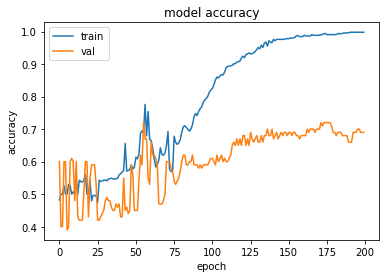

In [110]:
plot_accuracy(history)

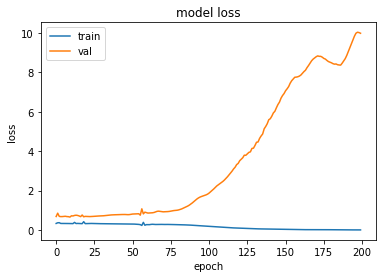

In [111]:
plot_loss(history)

In [112]:
precision_scores, recall_scores, results = cross_validate(epochs=75)

4/4 [==============================] - 0s 24ms/step - loss: 1.1921 - precision_31: 0.6000 - recall_31: 0.6750 - accuracy: 0.6900 - weighted_accuracy: 0.6900


In [113]:
print_report(precision_scores, recall_scores)

Speedup: 1.2208906032534352 +- 0.06077826119254357
Precision: 0.500451409816742 +- 0.02684052675213923
Recall: 0.7799999952316284 +- 0.06942622195999931


## Fewer kernels

In [264]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [265]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_292 (Conv2D)          (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_293 (Conv2D)          (None, 19, 19, 32)        4832      
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_294 (Conv2D)          (None, 7, 7, 24)          6936      
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 5, 5, 24)          5208      
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 3, 3, 16)       

In [266]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 0s 500ms/step - loss: 0.3333 - precision_115: 0.0000e+00 - recall_115: 0.0000e+00 - accuracy: 0.5975 - weighted_accuracy: 0.4979 - val_loss: 0.6899 - val_precision_115: 0.5385 - val_recall_115: 0.7000 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 2/500
1/1 [==============================] - 0s 87ms/step - loss: 0.3319 - precision_115: 0.4425 - recall_115: 0.6250 - accuracy: 0.5350 - weighted_accuracy: 0.5500 - val_loss: 0.6917 - val_precision_115: 0.4239 - val_recall_115: 0.9750 - val_accuracy: 0.4600 - val_weighted_accuracy: 0.4600
Epoch 3/500
1/1 [==============================] - 0s 158ms/step - loss: 0.3307 - precision_115: 0.4068 - recall_115: 0.9688 - accuracy: 0.4225 - weighted_accuracy: 0.5135 - val_loss: 0.6787 - val_precision_115: 0.6552 - val_recall_115: 0.4750 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 4/500
1/1 [==============================] - 0s 136ms/step - loss: 0.3288 - precision_115:

1/1 [==============================] - 0s 134ms/step - loss: 0.2710 - precision_115: 0.6488 - recall_115: 0.6812 - accuracy: 0.7250 - weighted_accuracy: 0.7177 - val_loss: 0.5842 - val_precision_115: 0.6170 - val_recall_115: 0.7250 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 29/500
1/1 [==============================] - 0s 77ms/step - loss: 0.2693 - precision_115: 0.6548 - recall_115: 0.6875 - accuracy: 0.7300 - weighted_accuracy: 0.7229 - val_loss: 0.6610 - val_precision_115: 0.5441 - val_recall_115: 0.9250 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 30/500
1/1 [==============================] - 0s 172ms/step - loss: 0.2754 - precision_115: 0.5556 - recall_115: 0.8750 - accuracy: 0.6700 - weighted_accuracy: 0.7042 - val_loss: 0.5831 - val_precision_115: 0.6279 - val_recall_115: 0.6750 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 31/500
1/1 [==============================] - 0s 181ms/step - loss: 0.2669 - precision_115: 0.6646 - recall_

1/1 [==============================] - 0s 100ms/step - loss: 0.2270 - precision_115: 0.8069 - recall_115: 0.7312 - accuracy: 0.8225 - weighted_accuracy: 0.8073 - val_loss: 0.7678 - val_precision_115: 0.4810 - val_recall_115: 0.9500 - val_accuracy: 0.5700 - val_weighted_accuracy: 0.5700
Epoch 56/500
1/1 [==============================] - 0s 114ms/step - loss: 0.2447 - precision_115: 0.5639 - recall_115: 0.9375 - accuracy: 0.6850 - weighted_accuracy: 0.7271 - val_loss: 0.6219 - val_precision_115: 0.6078 - val_recall_115: 0.7750 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 57/500
1/1 [==============================] - 0s 150ms/step - loss: 0.2114 - precision_115: 0.7405 - recall_115: 0.8562 - accuracy: 0.8225 - weighted_accuracy: 0.8281 - val_loss: 0.6120 - val_precision_115: 0.6296 - val_recall_115: 0.4250 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 58/500
1/1 [==============================] - 0s 116ms/step - loss: 0.2431 - precision_115: 0.8273 - recall

1/1 [==============================] - 0s 53ms/step - loss: 0.1664 - precision_115: 0.8581 - recall_115: 0.8313 - accuracy: 0.8775 - weighted_accuracy: 0.8698 - val_loss: 0.7233 - val_precision_115: 0.5574 - val_recall_115: 0.8500 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 83/500
1/1 [==============================] - 0s 41ms/step - loss: 0.1619 - precision_115: 0.7632 - recall_115: 0.9062 - accuracy: 0.8500 - weighted_accuracy: 0.8594 - val_loss: 0.6935 - val_precision_115: 0.6000 - val_recall_115: 0.8250 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 84/500
1/1 [==============================] - 0s 35ms/step - loss: 0.1562 - precision_115: 0.8218 - recall_115: 0.8938 - accuracy: 0.8800 - weighted_accuracy: 0.8823 - val_loss: 0.6719 - val_precision_115: 0.6429 - val_recall_115: 0.6750 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 85/500
1/1 [==============================] - 0s 34ms/step - loss: 0.1576 - precision_115: 0.8608 - recall_115

1/1 [==============================] - 0s 49ms/step - loss: 0.1069 - precision_115: 0.8432 - recall_115: 0.9750 - accuracy: 0.9175 - weighted_accuracy: 0.9271 - val_loss: 0.8901 - val_precision_115: 0.5172 - val_recall_115: 0.7500 - val_accuracy: 0.6200 - val_weighted_accuracy: 0.6200
Epoch 110/500
1/1 [==============================] - 0s 45ms/step - loss: 0.1065 - precision_115: 0.8603 - recall_115: 0.9625 - accuracy: 0.9225 - weighted_accuracy: 0.9292 - val_loss: 0.8597 - val_precision_115: 0.5417 - val_recall_115: 0.6500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 111/500
1/1 [==============================] - 0s 43ms/step - loss: 0.1088 - precision_115: 0.9062 - recall_115: 0.9062 - accuracy: 0.9250 - weighted_accuracy: 0.9219 - val_loss: 0.8974 - val_precision_115: 0.5254 - val_recall_115: 0.7750 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 112/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1002 - precision_115: 0.8715 - recall_

1/1 [==============================] - 0s 58ms/step - loss: 0.0630 - precision_115: 0.8820 - recall_115: 0.9812 - accuracy: 0.9400 - weighted_accuracy: 0.9469 - val_loss: 1.0499 - val_precision_115: 0.5909 - val_recall_115: 0.6500 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 137/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0490 - precision_115: 0.9812 - recall_115: 0.9812 - accuracy: 0.9850 - weighted_accuracy: 0.9844 - val_loss: 1.0669 - val_precision_115: 0.5952 - val_recall_115: 0.6250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 138/500
1/1 [==============================] - 0s 44ms/step - loss: 0.0502 - precision_115: 0.9873 - recall_115: 0.9688 - accuracy: 0.9825 - weighted_accuracy: 0.9802 - val_loss: 1.2112 - val_precision_115: 0.5238 - val_recall_115: 0.8250 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 139/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0601 - precision_115: 0.8820 - recall_

1/1 [==============================] - 0s 44ms/step - loss: 0.0177 - precision_115: 1.0000 - recall_115: 0.9875 - accuracy: 0.9950 - weighted_accuracy: 0.9938 - val_loss: 1.3799 - val_precision_115: 0.5490 - val_recall_115: 0.7000 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 164/500
1/1 [==============================] - 0s 39ms/step - loss: 0.0170 - precision_115: 0.9937 - recall_115: 0.9937 - accuracy: 0.9950 - weighted_accuracy: 0.9948 - val_loss: 1.3874 - val_precision_115: 0.5625 - val_recall_115: 0.6750 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 165/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0159 - precision_115: 1.0000 - recall_115: 0.9875 - accuracy: 0.9950 - weighted_accuracy: 0.9938 - val_loss: 1.3969 - val_precision_115: 0.5745 - val_recall_115: 0.6750 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 166/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0153 - precision_115: 1.0000 - recall_

1/1 [==============================] - 0s 45ms/step - loss: 0.0053 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.7164 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 191/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0051 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.7120 - val_precision_115: 0.5745 - val_recall_115: 0.6750 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 192/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0049 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.7228 - val_precision_115: 0.5745 - val_recall_115: 0.6750 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 193/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0048 - precision_115: 1.0000 - recall_

1/1 [==============================] - 0s 45ms/step - loss: 0.0021 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.9929 - val_precision_115: 0.5957 - val_recall_115: 0.7000 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 218/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0020 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.0008 - val_precision_115: 0.5957 - val_recall_115: 0.7000 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 219/500
1/1 [==============================] - 0s 40ms/step - loss: 0.0020 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.0133 - val_precision_115: 0.5957 - val_recall_115: 0.7000 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 220/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0019 - precision_115: 1.0000 - recall_

1/1 [==============================] - 0s 51ms/step - loss: 0.0011 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2011 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 245/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0010 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2037 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 246/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0010 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2111 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 247/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0010 - precision_115: 1.0000 - recall_

1/1 [==============================] - 0s 56ms/step - loss: 6.3852e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.3595 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 272/500
1/1 [==============================] - 0s 46ms/step - loss: 6.2752e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.3657 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 273/500
1/1 [==============================] - 0s 46ms/step - loss: 6.1720e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.3724 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 274/500
1/1 [==============================] - 0s 46ms/step - loss: 6.0720e-04 - precision_115: 

Epoch 298/500
1/1 [==============================] - 0s 42ms/step - loss: 4.1327e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.5259 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 299/500
1/1 [==============================] - 0s 34ms/step - loss: 4.0431e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.5351 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 300/500
1/1 [==============================] - 0s 52ms/step - loss: 3.9417e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.5439 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 301/500
1/1 [==============================] - 0s 46ms/step - loss: 3.8541e-04 - p

Epoch 325/500
1/1 [==============================] - 0s 41ms/step - loss: 2.2806e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7108 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 326/500
1/1 [==============================] - 0s 33ms/step - loss: 2.2330e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7159 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 327/500
1/1 [==============================] - 0s 51ms/step - loss: 2.1870e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7223 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 328/500
1/1 [==============================] - 0s 37ms/step - loss: 2.1410e-04 - p

Epoch 352/500
1/1 [==============================] - 0s 43ms/step - loss: 1.3334e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.8701 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 353/500
1/1 [==============================] - 0s 34ms/step - loss: 1.3092e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.8747 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 354/500
1/1 [==============================] - 0s 58ms/step - loss: 1.2852e-04 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.8794 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 355/500
1/1 [==============================] - 0s 60ms/step - loss: 1.2618e-04 - p

Epoch 379/500
1/1 [==============================] - 0s 52ms/step - loss: 8.4345e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.9966 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 380/500
1/1 [==============================] - 0s 43ms/step - loss: 8.3066e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.0015 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 381/500
1/1 [==============================] - 0s 52ms/step - loss: 8.1792e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.0066 - val_precision_115: 0.5714 - val_recall_115: 0.7000 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 382/500
1/1 [==============================] - 0s 39ms/step - loss: 8.0535e-05 - p

Epoch 406/500
1/1 [==============================] - 0s 55ms/step - loss: 5.7680e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1037 - val_precision_115: 0.5957 - val_recall_115: 0.7000 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 407/500
1/1 [==============================] - 0s 47ms/step - loss: 5.6953e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1072 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 408/500
1/1 [==============================] - 0s 51ms/step - loss: 5.6244e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1108 - val_precision_115: 0.5833 - val_recall_115: 0.7000 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 409/500
1/1 [==============================] - 0s 44ms/step - loss: 5.5546e-05 - p

Epoch 433/500
1/1 [==============================] - 0s 45ms/step - loss: 4.2009e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1907 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 434/500
1/1 [==============================] - 0s 43ms/step - loss: 4.1565e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1935 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 435/500
1/1 [==============================] - 0s 65ms/step - loss: 4.1129e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1964 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 436/500
1/1 [==============================] - 0s 45ms/step - loss: 4.0695e-05 - p

Epoch 460/500
1/1 [==============================] - 0s 29ms/step - loss: 3.2036e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.2667 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 461/500
1/1 [==============================] - 0s 42ms/step - loss: 3.1740e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.2693 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 462/500
1/1 [==============================] - 0s 62ms/step - loss: 3.1450e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.2719 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 463/500
1/1 [==============================] - 0s 53ms/step - loss: 3.1166e-05 - p

Epoch 487/500
1/1 [==============================] - 0s 48ms/step - loss: 2.5355e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.3321 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 488/500
1/1 [==============================] - 0s 42ms/step - loss: 2.5150e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.3343 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 489/500
1/1 [==============================] - 0s 42ms/step - loss: 2.4946e-05 - precision_115: 1.0000 - recall_115: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.3365 - val_precision_115: 0.6087 - val_recall_115: 0.7000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 490/500
1/1 [==============================] - 0s 48ms/step - loss: 2.4745e-05 - p

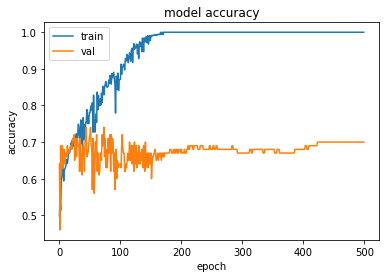

In [267]:
plot_accuracy(history)

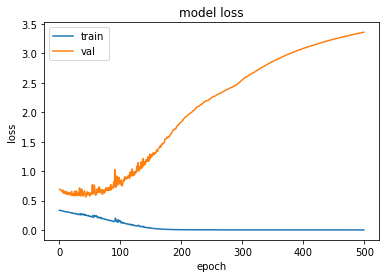

In [268]:
plot_loss(history)

In [270]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=50, learning_rate=0.001)

4/4 [==============================] - 0s 8ms/step - loss: 0.5812 - precision_120: 0.6444 - recall_120: 0.7250 - accuracy: 0.7300 - weighted_accuracy: 0.7300


In [273]:
print_report(precision_scores, recall_scores)

Speedup: 1.7787006726898102 +- 0.034914991968339755
Precision: 0.741094434261322 +- 0.01581283556468011
Recall: 0.8499999880790711 +- 0.029154758247573586


### Fewer fewer

In [157]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(3, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(16, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(12, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(12, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(8, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [158]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 47, 47, 3)         153       
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 23, 23, 3)         0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 19, 19, 16)        1216      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 7, 7, 12)          1740      
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 5, 5, 12)          1308      
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 3, 3, 8)         

In [159]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 0s 422ms/step - loss: 0.3327 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6932 - val_precision_40: 0.4021 - val_recall_40: 0.9750 - val_accuracy: 0.4100 - val_weighted_accuracy: 0.4100
Epoch 2/500
1/1 [==============================] - 0s 94ms/step - loss: 0.3327 - precision_40: 0.4041 - recall_40: 0.9875 - accuracy: 0.4125 - weighted_accuracy: 0.5083 - val_loss: 0.6931 - val_precision_40: 0.4079 - val_recall_40: 0.7750 - val_accuracy: 0.4600 - val_weighted_accuracy: 0.4600
Epoch 3/500
1/1 [==============================] - 0s 49ms/step - loss: 0.3327 - precision_40: 0.4375 - recall_40: 0.8313 - accuracy: 0.5050 - weighted_accuracy: 0.5594 - val_loss: 0.6929 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/500
1/1 [==============================] - 0s 68ms/step - loss: 0.3327 - precision_40: 0.0000

Epoch 56/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3002 - precision_40: 0.5644 - recall_40: 0.7125 - accuracy: 0.6650 - weighted_accuracy: 0.6729 - val_loss: 0.7560 - val_precision_40: 0.4898 - val_recall_40: 0.6000 - val_accuracy: 0.5900 - val_weighted_accuracy: 0.5900
Epoch 57/500
1/1 [==============================] - 0s 51ms/step - loss: 0.2988 - precision_40: 0.5672 - recall_40: 0.7125 - accuracy: 0.6675 - weighted_accuracy: 0.6750 - val_loss: 0.7773 - val_precision_40: 0.4531 - val_recall_40: 0.7250 - val_accuracy: 0.5400 - val_weighted_accuracy: 0.5400
Epoch 58/500
1/1 [==============================] - 0s 107ms/step - loss: 0.3006 - precision_40: 0.5201 - recall_40: 0.8875 - accuracy: 0.6275 - weighted_accuracy: 0.6708 - val_loss: 0.7562 - val_precision_40: 0.5111 - val_recall_40: 0.5750 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 59/500
1/1 [==============================] - 0s 78ms/step - loss: 0.2972 - precision_40: 0.5789 - recall_40

Epoch 84/500
1/1 [==============================] - 0s 94ms/step - loss: 0.2745 - precision_40: 0.5812 - recall_40: 0.8500 - accuracy: 0.6950 - weighted_accuracy: 0.7208 - val_loss: 0.7137 - val_precision_40: 0.5455 - val_recall_40: 0.6000 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 85/500
1/1 [==============================] - 0s 76ms/step - loss: 0.2802 - precision_40: 0.6415 - recall_40: 0.6375 - accuracy: 0.7125 - weighted_accuracy: 0.7000 - val_loss: 0.7224 - val_precision_40: 0.5306 - val_recall_40: 0.6500 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 86/500
1/1 [==============================] - 0s 76ms/step - loss: 0.2735 - precision_40: 0.6169 - recall_40: 0.7750 - accuracy: 0.7175 - weighted_accuracy: 0.7271 - val_loss: 0.7582 - val_precision_40: 0.4839 - val_recall_40: 0.7500 - val_accuracy: 0.5800 - val_weighted_accuracy: 0.5800
Epoch 87/500
1/1 [==============================] - 0s 115ms/step - loss: 0.2769 - precision_40: 0.5551 - recall_40

Epoch 112/500
1/1 [==============================] - 0s 49ms/step - loss: 0.2594 - precision_40: 0.5664 - recall_40: 0.9062 - accuracy: 0.6850 - weighted_accuracy: 0.7219 - val_loss: 0.7039 - val_precision_40: 0.5319 - val_recall_40: 0.6250 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 113/500
1/1 [==============================] - 0s 65ms/step - loss: 0.2581 - precision_40: 0.6686 - recall_40: 0.7188 - accuracy: 0.7450 - weighted_accuracy: 0.7406 - val_loss: 0.7419 - val_precision_40: 0.5345 - val_recall_40: 0.7750 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 114/500
1/1 [==============================] - 0s 45ms/step - loss: 0.2549 - precision_40: 0.5854 - recall_40: 0.9000 - accuracy: 0.7050 - weighted_accuracy: 0.7375 - val_loss: 0.7118 - val_precision_40: 0.5385 - val_recall_40: 0.7000 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 115/500
1/1 [==============================] - 0s 42ms/step - loss: 0.2508 - precision_40: 0.6364 - recall

Epoch 140/500
1/1 [==============================] - 0s 80ms/step - loss: 0.2465 - precision_40: 0.6017 - recall_40: 0.9062 - accuracy: 0.7225 - weighted_accuracy: 0.7531 - val_loss: 0.7525 - val_precision_40: 0.5068 - val_recall_40: 0.9250 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 141/500
1/1 [==============================] - 0s 109ms/step - loss: 0.2781 - precision_40: 0.5310 - recall_40: 0.9625 - accuracy: 0.6450 - weighted_accuracy: 0.6979 - val_loss: 0.7191 - val_precision_40: 0.5075 - val_recall_40: 0.8500 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 142/500
1/1 [==============================] - 0s 125ms/step - loss: 0.2608 - precision_40: 0.5651 - recall_40: 0.9500 - accuracy: 0.6875 - weighted_accuracy: 0.7313 - val_loss: 0.6790 - val_precision_40: 0.5122 - val_recall_40: 0.5250 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 143/500
1/1 [==============================] - 0s 64ms/step - loss: 0.2581 - precision_40: 0.6774 - reca

Epoch 168/500
1/1 [==============================] - 0s 59ms/step - loss: 0.2389 - precision_40: 0.6043 - recall_40: 0.8875 - accuracy: 0.7225 - weighted_accuracy: 0.7500 - val_loss: 0.6757 - val_precision_40: 0.5357 - val_recall_40: 0.7500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 169/500
1/1 [==============================] - 0s 94ms/step - loss: 0.2375 - precision_40: 0.6096 - recall_40: 0.8687 - accuracy: 0.7250 - weighted_accuracy: 0.7490 - val_loss: 0.6665 - val_precision_40: 0.5472 - val_recall_40: 0.7250 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 170/500
1/1 [==============================] - 0s 83ms/step - loss: 0.2382 - precision_40: 0.6649 - recall_40: 0.8062 - accuracy: 0.7600 - weighted_accuracy: 0.7677 - val_loss: 0.6673 - val_precision_40: 0.5556 - val_recall_40: 0.7500 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 171/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2372 - precision_40: 0.6650 - recall

Epoch 196/500
1/1 [==============================] - 0s 77ms/step - loss: 0.2290 - precision_40: 0.6384 - recall_40: 0.8938 - accuracy: 0.7550 - weighted_accuracy: 0.7781 - val_loss: 0.6902 - val_precision_40: 0.5556 - val_recall_40: 0.7500 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 197/500
1/1 [==============================] - 0s 93ms/step - loss: 0.2288 - precision_40: 0.6588 - recall_40: 0.8687 - accuracy: 0.7675 - weighted_accuracy: 0.7844 - val_loss: 0.6925 - val_precision_40: 0.5357 - val_recall_40: 0.7500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 198/500
1/1 [==============================] - 0s 102ms/step - loss: 0.2286 - precision_40: 0.6605 - recall_40: 0.8875 - accuracy: 0.7725 - weighted_accuracy: 0.7917 - val_loss: 0.6967 - val_precision_40: 0.5263 - val_recall_40: 0.7500 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 199/500
1/1 [==============================] - 0s 94ms/step - loss: 0.2286 - precision_40: 0.6500 - recal

Epoch 224/500
1/1 [==============================] - 0s 95ms/step - loss: 0.2338 - precision_40: 0.6008 - recall_40: 0.9500 - accuracy: 0.7275 - weighted_accuracy: 0.7646 - val_loss: 0.7113 - val_precision_40: 0.5472 - val_recall_40: 0.7250 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 225/500
1/1 [==============================] - 0s 75ms/step - loss: 0.2242 - precision_40: 0.6782 - recall_40: 0.8562 - accuracy: 0.7800 - weighted_accuracy: 0.7927 - val_loss: 0.7134 - val_precision_40: 0.5472 - val_recall_40: 0.7250 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 226/500
1/1 [==============================] - 0s 97ms/step - loss: 0.2228 - precision_40: 0.6698 - recall_40: 0.8875 - accuracy: 0.7800 - weighted_accuracy: 0.7979 - val_loss: 0.7203 - val_precision_40: 0.5439 - val_recall_40: 0.7750 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 227/500
1/1 [==============================] - 0s 90ms/step - loss: 0.2261 - precision_40: 0.6192 - recall

Epoch 252/500
1/1 [==============================] - 0s 86ms/step - loss: 0.2181 - precision_40: 0.6667 - recall_40: 0.8875 - accuracy: 0.7775 - weighted_accuracy: 0.7958 - val_loss: 0.7107 - val_precision_40: 0.5357 - val_recall_40: 0.7500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 253/500
1/1 [==============================] - 0s 87ms/step - loss: 0.2184 - precision_40: 0.6460 - recall_40: 0.9125 - accuracy: 0.7650 - weighted_accuracy: 0.7896 - val_loss: 0.7049 - val_precision_40: 0.5455 - val_recall_40: 0.7500 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 254/500
1/1 [==============================] - 0s 93ms/step - loss: 0.2181 - precision_40: 0.6863 - recall_40: 0.8750 - accuracy: 0.7900 - weighted_accuracy: 0.8042 - val_loss: 0.7051 - val_precision_40: 0.5357 - val_recall_40: 0.7500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 255/500
1/1 [==============================] - 0s 124ms/step - loss: 0.2180 - precision_40: 0.6518 - recal

Epoch 280/500
1/1 [==============================] - 0s 73ms/step - loss: 0.2109 - precision_40: 0.6777 - recall_40: 0.8938 - accuracy: 0.7875 - weighted_accuracy: 0.8052 - val_loss: 0.7166 - val_precision_40: 0.5556 - val_recall_40: 0.7500 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 281/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2110 - precision_40: 0.7065 - recall_40: 0.8875 - accuracy: 0.8075 - weighted_accuracy: 0.8208 - val_loss: 0.7197 - val_precision_40: 0.5593 - val_recall_40: 0.8250 - val_accuracy: 0.6700 - val_weighted_accuracy: 0.6700
Epoch 282/500
1/1 [==============================] - 0s 59ms/step - loss: 0.2121 - precision_40: 0.6476 - recall_40: 0.9187 - accuracy: 0.7675 - weighted_accuracy: 0.7927 - val_loss: 0.7165 - val_precision_40: 0.5577 - val_recall_40: 0.7250 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 283/500
1/1 [==============================] - 0s 102ms/step - loss: 0.2131 - precision_40: 0.7150 - recal

Epoch 308/500
1/1 [==============================] - 0s 75ms/step - loss: 0.2029 - precision_40: 0.7165 - recall_40: 0.8687 - accuracy: 0.8100 - weighted_accuracy: 0.8198 - val_loss: 0.7540 - val_precision_40: 0.5690 - val_recall_40: 0.8250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 309/500
1/1 [==============================] - 0s 91ms/step - loss: 0.2059 - precision_40: 0.6422 - recall_40: 0.9312 - accuracy: 0.7650 - weighted_accuracy: 0.7927 - val_loss: 0.7685 - val_precision_40: 0.5800 - val_recall_40: 0.7250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 310/500
1/1 [==============================] - 0s 65ms/step - loss: 0.2048 - precision_40: 0.7263 - recall_40: 0.8625 - accuracy: 0.8150 - weighted_accuracy: 0.8229 - val_loss: 0.7566 - val_precision_40: 0.5690 - val_recall_40: 0.8250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 311/500
1/1 [==============================] - 0s 86ms/step - loss: 0.2027 - precision_40: 0.6522 - recall

Epoch 336/500
1/1 [==============================] - 0s 77ms/step - loss: 0.1868 - precision_40: 0.6881 - recall_40: 0.9375 - accuracy: 0.8050 - weighted_accuracy: 0.8271 - val_loss: 0.8019 - val_precision_40: 0.5962 - val_recall_40: 0.7750 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 337/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1843 - precision_40: 0.7100 - recall_40: 0.8875 - accuracy: 0.8100 - weighted_accuracy: 0.8229 - val_loss: 0.8001 - val_precision_40: 0.5849 - val_recall_40: 0.7750 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 338/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1828 - precision_40: 0.6948 - recall_40: 0.9250 - accuracy: 0.8075 - weighted_accuracy: 0.8271 - val_loss: 0.8092 - val_precision_40: 0.5769 - val_recall_40: 0.7500 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 339/500
1/1 [==============================] - 0s 70ms/step - loss: 0.1824 - precision_40: 0.7073 - recall

Epoch 364/500
1/1 [==============================] - 0s 73ms/step - loss: 0.2113 - precision_40: 0.6135 - recall_40: 0.9625 - accuracy: 0.7425 - weighted_accuracy: 0.7792 - val_loss: 0.7128 - val_precision_40: 0.5862 - val_recall_40: 0.8500 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 365/500
1/1 [==============================] - 0s 93ms/step - loss: 0.2003 - precision_40: 0.6349 - recall_40: 0.9563 - accuracy: 0.7625 - weighted_accuracy: 0.7948 - val_loss: 0.7585 - val_precision_40: 0.5800 - val_recall_40: 0.7250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 366/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1789 - precision_40: 0.7327 - recall_40: 0.9250 - accuracy: 0.8350 - weighted_accuracy: 0.8500 - val_loss: 0.8813 - val_precision_40: 0.6250 - val_recall_40: 0.6250 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 367/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1992 - precision_40: 0.7826 - recall

Epoch 392/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1573 - precision_40: 0.7656 - recall_40: 0.9187 - accuracy: 0.8550 - weighted_accuracy: 0.8656 - val_loss: 0.6993 - val_precision_40: 0.5962 - val_recall_40: 0.7750 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 393/500
1/1 [==============================] - 0s 85ms/step - loss: 0.1598 - precision_40: 0.7424 - recall_40: 0.9187 - accuracy: 0.8400 - weighted_accuracy: 0.8531 - val_loss: 0.7146 - val_precision_40: 0.6078 - val_recall_40: 0.7750 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 394/500
1/1 [==============================] - 0s 69ms/step - loss: 0.1565 - precision_40: 0.7641 - recall_40: 0.9312 - accuracy: 0.8575 - weighted_accuracy: 0.8698 - val_loss: 0.7544 - val_precision_40: 0.6304 - val_recall_40: 0.7250 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 395/500
1/1 [==============================] - 0s 87ms/step - loss: 0.1556 - precision_40: 0.7778 - recall

Epoch 420/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1354 - precision_40: 0.8066 - recall_40: 0.9125 - accuracy: 0.8775 - weighted_accuracy: 0.8833 - val_loss: 0.7868 - val_precision_40: 0.6818 - val_recall_40: 0.7500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 421/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1347 - precision_40: 0.8033 - recall_40: 0.9187 - accuracy: 0.8775 - weighted_accuracy: 0.8844 - val_loss: 0.7966 - val_precision_40: 0.6667 - val_recall_40: 0.7500 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 422/500
1/1 [==============================] - 0s 64ms/step - loss: 0.1340 - precision_40: 0.7989 - recall_40: 0.9187 - accuracy: 0.8750 - weighted_accuracy: 0.8823 - val_loss: 0.7963 - val_precision_40: 0.6522 - val_recall_40: 0.7500 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 423/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1331 - precision_40: 0.7989 - recall

Epoch 448/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1140 - precision_40: 0.8380 - recall_40: 0.9375 - accuracy: 0.9025 - weighted_accuracy: 0.9083 - val_loss: 0.8371 - val_precision_40: 0.6667 - val_recall_40: 0.7500 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 449/500
1/1 [==============================] - 0s 94ms/step - loss: 0.1139 - precision_40: 0.8108 - recall_40: 0.9375 - accuracy: 0.8875 - weighted_accuracy: 0.8958 - val_loss: 0.8853 - val_precision_40: 0.6522 - val_recall_40: 0.7500 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 450/500
1/1 [==============================] - 0s 83ms/step - loss: 0.1159 - precision_40: 0.8142 - recall_40: 0.9312 - accuracy: 0.8875 - weighted_accuracy: 0.8948 - val_loss: 0.8557 - val_precision_40: 0.6818 - val_recall_40: 0.7500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 451/500
1/1 [==============================] - 0s 77ms/step - loss: 0.1113 - precision_40: 0.8297 - recall

Epoch 476/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0886 - precision_40: 0.8659 - recall_40: 0.9688 - accuracy: 0.9275 - weighted_accuracy: 0.9344 - val_loss: 1.0113 - val_precision_40: 0.6923 - val_recall_40: 0.6750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 477/500
1/1 [==============================] - 0s 84ms/step - loss: 0.0919 - precision_40: 0.8713 - recall_40: 0.9312 - accuracy: 0.9175 - weighted_accuracy: 0.9198 - val_loss: 0.9249 - val_precision_40: 0.6977 - val_recall_40: 0.7500 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 478/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0927 - precision_40: 0.8478 - recall_40: 0.9750 - accuracy: 0.9200 - weighted_accuracy: 0.9292 - val_loss: 0.9883 - val_precision_40: 0.6923 - val_recall_40: 0.6750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 479/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0881 - precision_40: 0.8743 - recall

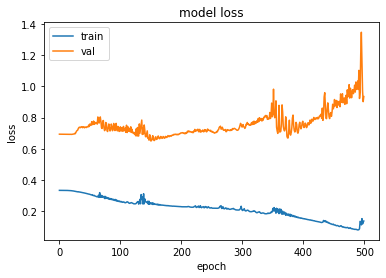

In [160]:
plot_loss(history)

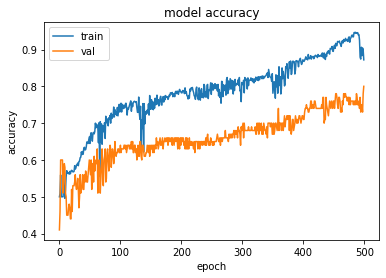

In [161]:
plot_accuracy(history)

In [163]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=150, learning_rate=0.001)

4/4 [==============================] - 0s 5ms/step - loss: 0.2709 - precision_45: 0.8571 - recall_45: 0.9000 - accuracy: 0.9000 - weighted_accuracy: 0.9000


In [164]:
print_report(precision_scores, recall_scores)

Speedup: 1.6565391956039892 +- 0.09599444632664147
Precision: 0.6894779801368713 +- 0.04145884348178052
Recall: 0.8 +- 0.028284269561588717


### More a bit

In [167]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(12, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(64, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(48, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(48, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(32, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [168]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_189 (Conv2D)          (None, 47, 47, 12)        612       
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 23, 23, 12)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 19, 19, 64)        19264     
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 7, 7, 48)          27696     
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 5, 5, 48)          20784     
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 3, 3, 32)        

In [169]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 1s 792ms/step - loss: 0.3327 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6933 - val_precision_46: 0.3980 - val_recall_46: 0.9750 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 2/500
1/1 [==============================] - 0s 44ms/step - loss: 0.3327 - precision_46: 0.4124 - recall_46: 1.0000 - accuracy: 0.4300 - weighted_accuracy: 0.5250 - val_loss: 0.6921 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 3/500
1/1 [==============================] - 0s 42ms/step - loss: 0.3326 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6915 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/500
1/1 [==============================] - 0s 57ms/step - loss: 0.3324 - prec

Epoch 56/500
1/1 [==============================] - 0s 46ms/step - loss: 0.2544 - precision_46: 0.6061 - recall_46: 0.8750 - accuracy: 0.7225 - weighted_accuracy: 0.7479 - val_loss: 0.6995 - val_precision_46: 0.5000 - val_recall_46: 0.1250 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 57/500
1/1 [==============================] - 0s 64ms/step - loss: 0.3012 - precision_46: 0.7541 - recall_46: 0.2875 - accuracy: 0.6775 - weighted_accuracy: 0.6125 - val_loss: 0.7326 - val_precision_46: 0.5147 - val_recall_46: 0.8750 - val_accuracy: 0.6200 - val_weighted_accuracy: 0.6200
Epoch 58/500
1/1 [==============================] - 0s 50ms/step - loss: 0.2754 - precision_46: 0.5429 - recall_46: 0.9500 - accuracy: 0.6600 - weighted_accuracy: 0.7083 - val_loss: 0.7512 - val_precision_46: 0.5000 - val_recall_46: 0.9000 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 59/500
1/1 [==============================] - 0s 40ms/step - loss: 0.2858 - precision_46: 0.5294 - recall_46:

Epoch 84/500
1/1 [==============================] - 0s 50ms/step - loss: 0.2380 - precision_46: 0.5939 - recall_46: 0.9688 - accuracy: 0.7225 - weighted_accuracy: 0.7635 - val_loss: 0.7169 - val_precision_46: 0.5294 - val_recall_46: 0.9000 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 85/500
1/1 [==============================] - 0s 60ms/step - loss: 0.2432 - precision_46: 0.5772 - recall_46: 0.9812 - accuracy: 0.7050 - weighted_accuracy: 0.7510 - val_loss: 0.6253 - val_precision_46: 0.6429 - val_recall_46: 0.6750 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 86/500
1/1 [==============================] - 0s 51ms/step - loss: 0.2139 - precision_46: 0.7056 - recall_46: 0.7937 - accuracy: 0.7850 - weighted_accuracy: 0.7865 - val_loss: 0.6416 - val_precision_46: 0.6667 - val_recall_46: 0.5000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 87/500
1/1 [==============================] - 0s 42ms/step - loss: 0.2305 - precision_46: 0.7533 - recall_46:

Epoch 112/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1664 - precision_46: 0.7663 - recall_46: 0.8813 - accuracy: 0.8450 - weighted_accuracy: 0.8510 - val_loss: 0.6799 - val_precision_46: 0.7209 - val_recall_46: 0.7750 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 113/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1637 - precision_46: 0.7688 - recall_46: 0.8938 - accuracy: 0.8500 - weighted_accuracy: 0.8573 - val_loss: 0.6929 - val_precision_46: 0.6471 - val_recall_46: 0.8250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 114/500
1/1 [==============================] - 0s 77ms/step - loss: 0.1643 - precision_46: 0.7340 - recall_46: 0.9312 - accuracy: 0.8375 - weighted_accuracy: 0.8531 - val_loss: 0.6976 - val_precision_46: 0.6531 - val_recall_46: 0.8000 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 115/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1596 - precision_46: 0.7424 - recall

Epoch 140/500
1/1 [==============================] - 0s 63ms/step - loss: 0.1193 - precision_46: 0.8353 - recall_46: 0.8875 - accuracy: 0.8850 - weighted_accuracy: 0.8854 - val_loss: 0.9207 - val_precision_46: 0.6531 - val_recall_46: 0.8000 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 141/500
1/1 [==============================] - 0s 62ms/step - loss: 0.1304 - precision_46: 0.7488 - recall_46: 0.9875 - accuracy: 0.8625 - weighted_accuracy: 0.8833 - val_loss: 1.0114 - val_precision_46: 0.7879 - val_recall_46: 0.6500 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 142/500
1/1 [==============================] - 0s 96ms/step - loss: 0.1168 - precision_46: 0.8512 - recall_46: 0.8938 - accuracy: 0.8950 - weighted_accuracy: 0.8948 - val_loss: 1.0172 - val_precision_46: 0.7879 - val_recall_46: 0.6500 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 143/500
1/1 [==============================] - 0s 63ms/step - loss: 0.1140 - precision_46: 0.8421 - recall

Epoch 168/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0911 - precision_46: 0.8564 - recall_46: 0.9688 - accuracy: 0.9225 - weighted_accuracy: 0.9302 - val_loss: 1.1478 - val_precision_46: 0.6744 - val_recall_46: 0.7250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 169/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0929 - precision_46: 0.8486 - recall_46: 0.9812 - accuracy: 0.9225 - weighted_accuracy: 0.9323 - val_loss: 1.1738 - val_precision_46: 0.7368 - val_recall_46: 0.7000 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 170/500
1/1 [==============================] - 0s 96ms/step - loss: 0.0929 - precision_46: 0.8659 - recall_46: 0.9688 - accuracy: 0.9275 - weighted_accuracy: 0.9344 - val_loss: 1.2534 - val_precision_46: 0.7297 - val_recall_46: 0.6750 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 171/500
1/1 [==============================] - 0s 85ms/step - loss: 0.0919 - precision_46: 0.8728 - recall

Epoch 196/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0678 - precision_46: 0.8883 - recall_46: 0.9937 - accuracy: 0.9475 - weighted_accuracy: 0.9552 - val_loss: 1.6767 - val_precision_46: 0.7353 - val_recall_46: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 197/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0657 - precision_46: 0.8927 - recall_46: 0.9875 - accuracy: 0.9475 - weighted_accuracy: 0.9542 - val_loss: 1.7351 - val_precision_46: 0.7500 - val_recall_46: 0.6000 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 198/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0655 - precision_46: 0.8977 - recall_46: 0.9875 - accuracy: 0.9500 - weighted_accuracy: 0.9563 - val_loss: 1.6249 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 199/500
1/1 [==============================] - 0s 106ms/step - loss: 0.0654 - precision_46: 0.8883 - recal

Epoch 224/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0806 - precision_46: 0.9030 - recall_46: 0.9312 - accuracy: 0.9325 - weighted_accuracy: 0.9323 - val_loss: 1.7032 - val_precision_46: 0.6304 - val_recall_46: 0.7250 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 225/500
1/1 [==============================] - 0s 74ms/step - loss: 0.0816 - precision_46: 0.8325 - recall_46: 0.9937 - accuracy: 0.9175 - weighted_accuracy: 0.9302 - val_loss: 1.5305 - val_precision_46: 0.6458 - val_recall_46: 0.7750 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 226/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0967 - precision_46: 0.8071 - recall_46: 0.9937 - accuracy: 0.9025 - weighted_accuracy: 0.9177 - val_loss: 1.6211 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 227/500
1/1 [==============================] - 0s 152ms/step - loss: 0.0837 - precision_46: 0.9096 - recal

Epoch 252/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0544 - precision_46: 0.9040 - recall_46: 1.0000 - accuracy: 0.9575 - weighted_accuracy: 0.9646 - val_loss: 2.2894 - val_precision_46: 0.6757 - val_recall_46: 0.6250 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 253/500
1/1 [==============================] - 0s 90ms/step - loss: 0.0532 - precision_46: 0.9040 - recall_46: 1.0000 - accuracy: 0.9575 - weighted_accuracy: 0.9646 - val_loss: 2.3161 - val_precision_46: 0.6944 - val_recall_46: 0.6250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 254/500
1/1 [==============================] - 0s 94ms/step - loss: 0.0530 - precision_46: 0.9034 - recall_46: 0.9937 - accuracy: 0.9550 - weighted_accuracy: 0.9615 - val_loss: 2.3248 - val_precision_46: 0.6944 - val_recall_46: 0.6250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 255/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0527 - precision_46: 0.9040 - recal

Epoch 280/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0397 - precision_46: 0.9302 - recall_46: 1.0000 - accuracy: 0.9700 - weighted_accuracy: 0.9750 - val_loss: 2.3184 - val_precision_46: 0.6757 - val_recall_46: 0.6250 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 281/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0394 - precision_46: 0.9302 - recall_46: 1.0000 - accuracy: 0.9700 - weighted_accuracy: 0.9750 - val_loss: 2.3903 - val_precision_46: 0.6757 - val_recall_46: 0.6250 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 282/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0391 - precision_46: 0.9357 - recall_46: 1.0000 - accuracy: 0.9725 - weighted_accuracy: 0.9771 - val_loss: 2.3393 - val_precision_46: 0.6757 - val_recall_46: 0.6250 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 283/500
1/1 [==============================] - 0s 91ms/step - loss: 0.0385 - precision_46: 0.9357 - recall

Epoch 308/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0293 - precision_46: 0.9464 - recall_46: 0.9937 - accuracy: 0.9750 - weighted_accuracy: 0.9781 - val_loss: 2.7876 - val_precision_46: 0.6944 - val_recall_46: 0.6250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 309/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0288 - precision_46: 0.9578 - recall_46: 0.9937 - accuracy: 0.9800 - weighted_accuracy: 0.9823 - val_loss: 2.7188 - val_precision_46: 0.6944 - val_recall_46: 0.6250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 310/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0281 - precision_46: 0.9636 - recall_46: 0.9937 - accuracy: 0.9825 - weighted_accuracy: 0.9844 - val_loss: 2.7183 - val_precision_46: 0.6944 - val_recall_46: 0.6250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 311/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0278 - precision_46: 0.9636 - recall

Epoch 336/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0180 - precision_46: 0.9697 - recall_46: 1.0000 - accuracy: 0.9875 - weighted_accuracy: 0.9896 - val_loss: 3.2442 - val_precision_46: 0.7188 - val_recall_46: 0.5750 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 337/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0184 - precision_46: 0.9755 - recall_46: 0.9937 - accuracy: 0.9875 - weighted_accuracy: 0.9885 - val_loss: 2.9972 - val_precision_46: 0.7105 - val_recall_46: 0.6750 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 338/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0182 - precision_46: 0.9697 - recall_46: 1.0000 - accuracy: 0.9875 - weighted_accuracy: 0.9896 - val_loss: 3.1828 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 339/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0166 - precision_46: 0.9755 - recall

Epoch 364/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0057 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 4.0394 - val_precision_46: 0.7353 - val_recall_46: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 365/500
1/1 [==============================] - 0s 44ms/step - loss: 0.0052 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 4.0734 - val_precision_46: 0.7353 - val_recall_46: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 366/500
1/1 [==============================] - 0s 81ms/step - loss: 0.0051 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 4.0221 - val_precision_46: 0.7273 - val_recall_46: 0.6000 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 367/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0050 - precision_46: 1.0000 - recall

Epoch 392/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0013 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 4.9078 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 393/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0012 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 4.9705 - val_precision_46: 0.7353 - val_recall_46: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 394/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0011 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 5.0336 - val_precision_46: 0.7353 - val_recall_46: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 395/500
1/1 [==============================] - 0s 104ms/step - loss: 0.0011 - precision_46: 1.0000 - reca

1/1 [==============================] - 0s 98ms/step - loss: 2.7713e-04 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 5.9405 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 447/500
1/1 [==============================] - 0s 73ms/step - loss: 2.7255e-04 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 5.9583 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 448/500
1/1 [==============================] - 0s 89ms/step - loss: 2.6792e-04 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 5.9623 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 449/500
1/1 [==============================] - 0s 79ms/step - loss: 2.6273e-04 - precision_46: 1.0000 - reca

1/1 [==============================] - 0s 102ms/step - loss: 1.2519e-04 - precision_46: 1.0000 - recall_46: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 6.3746 - val_precision_46: 0.7143 - val_recall_46: 0.6250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500


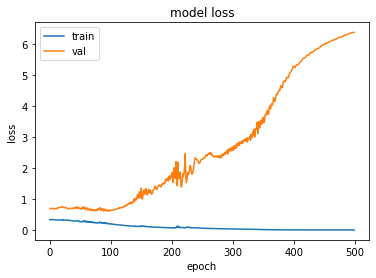

In [170]:
plot_loss(history)

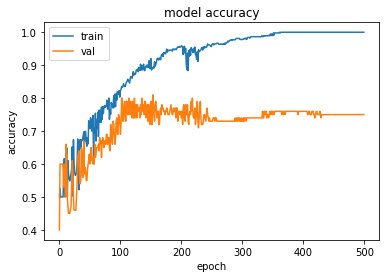

In [171]:
plot_accuracy(history)

In [172]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=100, learning_rate=0.001)

4/4 [==============================] - 0s 8ms/step - loss: 0.3593 - precision_51: 0.7391 - recall_51: 0.8500 - accuracy: 0.8200 - weighted_accuracy: 0.8200


In [173]:
print_report(precision_scores, recall_scores)

Speedup: 1.6953536285234858 +- 0.04078721111040274
Precision: 0.7061403512954711 +- 0.017924545740106334
Recall: 0.8100000023841858 +- 0.018165907768125728


## Reduce the best stuff

In [189]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [191]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_271 (Conv2D)          (None, 47, 47, 6)         306       
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 19, 19, 32)        4832      
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_74 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_222 (Dense)            (None, 256)               663808    
_________________________________________________________________
dense_223 (Dense)            (None, 256)             

In [192]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 0s 359ms/step - loss: 0.3326 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6913 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 2/500
1/1 [==============================] - 0s 67ms/step - loss: 0.3324 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6903 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 3/500
1/1 [==============================] - 0s 108ms/step - loss: 0.3321 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6892 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/500
1/1 [==============================] - 0s 80ms/step - lo

Epoch 56/500
1/1 [==============================] - 0s 90ms/step - loss: 0.1788 - precision_60: 0.7358 - recall_60: 0.8875 - accuracy: 0.8275 - weighted_accuracy: 0.8375 - val_loss: 0.5630 - val_precision_60: 0.6296 - val_recall_60: 0.8500 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 57/500
1/1 [==============================] - 0s 82ms/step - loss: 0.1858 - precision_60: 0.6916 - recall_60: 0.9250 - accuracy: 0.8050 - weighted_accuracy: 0.8250 - val_loss: 0.5457 - val_precision_60: 0.7381 - val_recall_60: 0.7750 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 58/500
1/1 [==============================] - 0s 84ms/step - loss: 0.1781 - precision_60: 0.7273 - recall_60: 0.9000 - accuracy: 0.8250 - weighted_accuracy: 0.8375 - val_loss: 0.5467 - val_precision_60: 0.7714 - val_recall_60: 0.6750 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 59/500
1/1 [==============================] - 0s 79ms/step - loss: 0.1819 - precision_60: 0.7811 - recall_60:

Epoch 84/500
1/1 [==============================] - 0s 100ms/step - loss: 0.1520 - precision_60: 0.7604 - recall_60: 0.9125 - accuracy: 0.8500 - weighted_accuracy: 0.8604 - val_loss: 0.5688 - val_precision_60: 0.8108 - val_recall_60: 0.7500 - val_accuracy: 0.8300 - val_weighted_accuracy: 0.8300
Epoch 85/500
1/1 [==============================] - 0s 72ms/step - loss: 0.1515 - precision_60: 0.8150 - recall_60: 0.8813 - accuracy: 0.8725 - weighted_accuracy: 0.8740 - val_loss: 0.5653 - val_precision_60: 0.7895 - val_recall_60: 0.7500 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 86/500
1/1 [==============================] - 0s 72ms/step - loss: 0.1481 - precision_60: 0.7889 - recall_60: 0.8875 - accuracy: 0.8600 - weighted_accuracy: 0.8646 - val_loss: 0.5722 - val_precision_60: 0.6809 - val_recall_60: 0.8000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 87/500
1/1 [==============================] - 0s 120ms/step - loss: 0.1493 - precision_60: 0.7552 - recall_6

Epoch 112/500
1/1 [==============================] - 0s 78ms/step - loss: 0.1239 - precision_60: 0.7969 - recall_60: 0.9563 - accuracy: 0.8850 - weighted_accuracy: 0.8969 - val_loss: 0.6150 - val_precision_60: 0.7714 - val_recall_60: 0.6750 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 113/500
1/1 [==============================] - 0s 78ms/step - loss: 0.1219 - precision_60: 0.8529 - recall_60: 0.9062 - accuracy: 0.9000 - weighted_accuracy: 0.9010 - val_loss: 0.6122 - val_precision_60: 0.7750 - val_recall_60: 0.7750 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 114/500
1/1 [==============================] - 0s 97ms/step - loss: 0.1204 - precision_60: 0.8138 - recall_60: 0.9563 - accuracy: 0.8950 - weighted_accuracy: 0.9052 - val_loss: 0.6157 - val_precision_60: 0.7838 - val_recall_60: 0.7250 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 115/500
1/1 [==============================] - 0s 95ms/step - loss: 0.1192 - precision_60: 0.8371 - recall

Epoch 140/500
1/1 [==============================] - 0s 85ms/step - loss: 0.1006 - precision_60: 0.8516 - recall_60: 0.9688 - accuracy: 0.9200 - weighted_accuracy: 0.9281 - val_loss: 0.7085 - val_precision_60: 0.7429 - val_recall_60: 0.6500 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 141/500
1/1 [==============================] - 0s 93ms/step - loss: 0.0985 - precision_60: 0.8686 - recall_60: 0.9500 - accuracy: 0.9225 - weighted_accuracy: 0.9271 - val_loss: 0.7232 - val_precision_60: 0.7576 - val_recall_60: 0.6250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 142/500
1/1 [==============================] - 0s 113ms/step - loss: 0.0985 - precision_60: 0.8736 - recall_60: 0.9500 - accuracy: 0.9250 - weighted_accuracy: 0.9292 - val_loss: 0.7148 - val_precision_60: 0.7381 - val_recall_60: 0.7750 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 143/500
1/1 [==============================] - 0s 113ms/step - loss: 0.0993 - precision_60: 0.8516 - reca

Epoch 168/500
1/1 [==============================] - 0s 184ms/step - loss: 0.0783 - precision_60: 0.8870 - recall_60: 0.9812 - accuracy: 0.9425 - weighted_accuracy: 0.9490 - val_loss: 0.8807 - val_precision_60: 0.7632 - val_recall_60: 0.7250 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 169/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0783 - precision_60: 0.8771 - recall_60: 0.9812 - accuracy: 0.9375 - weighted_accuracy: 0.9448 - val_loss: 0.9344 - val_precision_60: 0.7576 - val_recall_60: 0.6250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 170/500
1/1 [==============================] - 0s 125ms/step - loss: 0.0802 - precision_60: 0.9112 - recall_60: 0.9625 - accuracy: 0.9475 - weighted_accuracy: 0.9500 - val_loss: 0.8872 - val_precision_60: 0.7317 - val_recall_60: 0.7500 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 171/500
1/1 [==============================] - 0s 84ms/step - loss: 0.0803 - precision_60: 0.8541 - reca

Epoch 196/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0595 - precision_60: 0.9398 - recall_60: 0.9750 - accuracy: 0.9650 - weighted_accuracy: 0.9667 - val_loss: 1.1092 - val_precision_60: 0.7317 - val_recall_60: 0.7500 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 197/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0617 - precision_60: 0.8785 - recall_60: 0.9937 - accuracy: 0.9425 - weighted_accuracy: 0.9510 - val_loss: 1.2012 - val_precision_60: 0.7576 - val_recall_60: 0.6250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 198/500
1/1 [==============================] - 0s 125ms/step - loss: 0.0615 - precision_60: 0.9451 - recall_60: 0.9688 - accuracy: 0.9650 - weighted_accuracy: 0.9656 - val_loss: 1.1226 - val_precision_60: 0.6889 - val_recall_60: 0.7750 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 199/500
1/1 [==============================] - 0s 95ms/step - loss: 0.0649 - precision_60: 0.8641 - recal

Epoch 224/500
1/1 [==============================] - 0s 91ms/step - loss: 0.0385 - precision_60: 0.9576 - recall_60: 0.9875 - accuracy: 0.9775 - weighted_accuracy: 0.9792 - val_loss: 1.4254 - val_precision_60: 0.7568 - val_recall_60: 0.7000 - val_accuracy: 0.7900 - val_weighted_accuracy: 0.7900
Epoch 225/500
1/1 [==============================] - 0s 115ms/step - loss: 0.0380 - precision_60: 0.9634 - recall_60: 0.9875 - accuracy: 0.9800 - weighted_accuracy: 0.9812 - val_loss: 1.3984 - val_precision_60: 0.7143 - val_recall_60: 0.7500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 226/500
1/1 [==============================] - 0s 108ms/step - loss: 0.0400 - precision_60: 0.9357 - recall_60: 1.0000 - accuracy: 0.9725 - weighted_accuracy: 0.9771 - val_loss: 1.4907 - val_precision_60: 0.7353 - val_recall_60: 0.6250 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 227/500
1/1 [==============================] - 0s 121ms/step - loss: 0.0403 - precision_60: 0.9691 - rec

Epoch 252/500
1/1 [==============================] - 0s 94ms/step - loss: 0.0224 - precision_60: 0.9697 - recall_60: 1.0000 - accuracy: 0.9875 - weighted_accuracy: 0.9896 - val_loss: 1.7546 - val_precision_60: 0.7500 - val_recall_60: 0.6750 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 253/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0218 - precision_60: 0.9816 - recall_60: 1.0000 - accuracy: 0.9925 - weighted_accuracy: 0.9938 - val_loss: 1.7556 - val_precision_60: 0.7179 - val_recall_60: 0.7000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 254/500
1/1 [==============================] - 0s 92ms/step - loss: 0.0212 - precision_60: 0.9756 - recall_60: 1.0000 - accuracy: 0.9900 - weighted_accuracy: 0.9917 - val_loss: 1.7657 - val_precision_60: 0.7179 - val_recall_60: 0.7000 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 255/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0207 - precision_60: 0.9756 - recall

Epoch 280/500
1/1 [==============================] - 0s 112ms/step - loss: 0.0111 - precision_60: 0.9938 - recall_60: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 2.0037 - val_precision_60: 0.7250 - val_recall_60: 0.7250 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 281/500
1/1 [==============================] - 0s 91ms/step - loss: 0.0108 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.0103 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 282/500
1/1 [==============================] - 0s 95ms/step - loss: 0.0105 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.0192 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 283/500
1/1 [==============================] - 0s 85ms/step - loss: 0.0102 - precision_60: 1.0000 - recal

Epoch 308/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0054 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2642 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 309/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0053 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2729 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 310/500
1/1 [==============================] - 0s 102ms/step - loss: 0.0051 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.2808 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 311/500
1/1 [==============================] - 0s 104ms/step - loss: 0.0050 - precision_60: 1.0000 - rec

Epoch 336/500
1/1 [==============================] - 0s 99ms/step - loss: 0.0029 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.4644 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 337/500
1/1 [==============================] - 0s 117ms/step - loss: 0.0029 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.4690 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 338/500
1/1 [==============================] - 0s 101ms/step - loss: 0.0028 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.4753 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 339/500
1/1 [==============================] - 0s 106ms/step - loss: 0.0028 - precision_60: 1.0000 - rec

Epoch 364/500
1/1 [==============================] - 0s 93ms/step - loss: 0.0018 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.6188 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 365/500
1/1 [==============================] - 0s 98ms/step - loss: 0.0018 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.6246 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 366/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0017 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.6300 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 367/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0017 - precision_60: 1.0000 - recall

Epoch 392/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7610 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 393/500
1/1 [==============================] - 0s 92ms/step - loss: 0.0012 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7663 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 394/500
1/1 [==============================] - 0s 107ms/step - loss: 0.0011 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.7707 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 395/500
1/1 [==============================] - 0s 100ms/step - loss: 0.0011 - precision_60: 1.0000 - reca

1/1 [==============================] - 0s 82ms/step - loss: 6.0565e-04 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.9947 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 447/500
1/1 [==============================] - 0s 138ms/step - loss: 5.9937e-04 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 2.9976 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 448/500
1/1 [==============================] - 0s 81ms/step - loss: 5.9272e-04 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.0006 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700
Epoch 449/500
1/1 [==============================] - 0s 98ms/step - loss: 5.8650e-04 - precision_60: 1.0000 - rec

1/1 [==============================] - 0s 70ms/step - loss: 3.5923e-04 - precision_60: 1.0000 - recall_60: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 3.1648 - val_precision_60: 0.7073 - val_recall_60: 0.7250 - val_accuracy: 0.7700 - val_weighted_accuracy: 0.7700


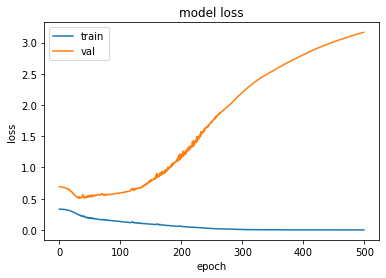

In [193]:
plot_loss(history)

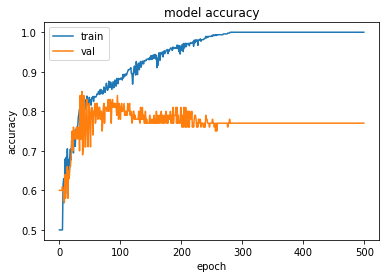

In [194]:
plot_accuracy(history)

In [195]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=50, learning_rate=0.001)

4/4 [==============================] - 0s 34ms/step - loss: 0.4116 - precision_65: 0.7551 - recall_65: 0.9250 - accuracy: 0.8500 - weighted_accuracy: 0.8500


In [196]:
print_report(precision_scores, recall_scores)

Speedup: 1.6589391743778243 +- 0.04232671664824003
Precision: 0.6890644073486328 +- 0.017429437969788054
Recall: 0.8299999952316284 +- 0.0486826480803323


### More reduce

In [197]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [199]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_285 (Conv2D)          (None, 47, 47, 6)         306       
_________________________________________________________________
max_pooling2d_195 (MaxPoolin (None, 23, 23, 6)         0         
_________________________________________________________________
flatten_81 (Flatten)         (None, 3174)              0         
_________________________________________________________________
dense_243 (Dense)            (None, 256)               812800    
_________________________________________________________________
dense_244 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_245 (Dense)            (None, 1)                 257       
Total params: 879,155
Trainable params: 879,155
Non-trainable params: 0
_______________________________________________

In [200]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=500, learning_rate=0.001)

Epoch 1/500
1/1 [==============================] - 0s 431ms/step - loss: 0.3327 - precision_66: 0.4331 - recall_66: 0.3438 - accuracy: 0.5575 - weighted_accuracy: 0.5219 - val_loss: 0.6926 - val_precision_66: 0.5263 - val_recall_66: 0.7500 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 2/500
1/1 [==============================] - 0s 71ms/step - loss: 0.3324 - precision_66: 0.5564 - recall_66: 0.8938 - accuracy: 0.6725 - weighted_accuracy: 0.7094 - val_loss: 0.6919 - val_precision_66: 0.5079 - val_recall_66: 0.8000 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 3/500
1/1 [==============================] - 0s 67ms/step - loss: 0.3320 - precision_66: 0.5370 - recall_66: 0.9062 - accuracy: 0.6500 - weighted_accuracy: 0.6927 - val_loss: 0.6902 - val_precision_66: 0.7391 - val_recall_66: 0.4250 - val_accuracy: 0.7100 - val_weighted_accuracy: 0.7100
Epoch 4/500
1/1 [==============================] - 0s 52ms/step - loss: 0.3315 - precision_66: 0.7885 - recall_66: 0.

Epoch 29/500
1/1 [==============================] - 0s 72ms/step - loss: 0.2416 - precision_66: 0.7289 - recall_66: 0.7563 - accuracy: 0.7900 - weighted_accuracy: 0.7844 - val_loss: 0.5377 - val_precision_66: 0.6596 - val_recall_66: 0.7750 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 30/500
1/1 [==============================] - 0s 78ms/step - loss: 0.2351 - precision_66: 0.6636 - recall_66: 0.9000 - accuracy: 0.7775 - weighted_accuracy: 0.7979 - val_loss: 0.5269 - val_precision_66: 0.6818 - val_recall_66: 0.7500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 31/500
1/1 [==============================] - 0s 112ms/step - loss: 0.2295 - precision_66: 0.6974 - recall_66: 0.8500 - accuracy: 0.7925 - weighted_accuracy: 0.8021 - val_loss: 0.5198 - val_precision_66: 0.6818 - val_recall_66: 0.7500 - val_accuracy: 0.7600 - val_weighted_accuracy: 0.7600
Epoch 32/500
1/1 [==============================] - 0s 92ms/step - loss: 0.2254 - precision_66: 0.7232 - recall_66

Epoch 57/500
1/1 [==============================] - 0s 67ms/step - loss: 0.1516 - precision_66: 0.8609 - recall_66: 0.8125 - accuracy: 0.8725 - weighted_accuracy: 0.8625 - val_loss: 0.4945 - val_precision_66: 0.7234 - val_recall_66: 0.8500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 58/500
1/1 [==============================] - 0s 81ms/step - loss: 0.1484 - precision_66: 0.7426 - recall_66: 0.9375 - accuracy: 0.8450 - weighted_accuracy: 0.8604 - val_loss: 0.4684 - val_precision_66: 0.8158 - val_recall_66: 0.7750 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 59/500
1/1 [==============================] - 0s 72ms/step - loss: 0.1378 - precision_66: 0.8198 - recall_66: 0.8813 - accuracy: 0.8750 - weighted_accuracy: 0.8760 - val_loss: 0.4743 - val_precision_66: 0.8333 - val_recall_66: 0.7500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 60/500
1/1 [==============================] - 0s 70ms/step - loss: 0.1393 - precision_66: 0.8438 - recall_66:

Epoch 85/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0976 - precision_66: 0.8750 - recall_66: 0.9187 - accuracy: 0.9150 - weighted_accuracy: 0.9156 - val_loss: 0.5198 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 86/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0958 - precision_66: 0.8663 - recall_66: 0.9312 - accuracy: 0.9150 - weighted_accuracy: 0.9177 - val_loss: 0.5218 - val_precision_66: 0.7632 - val_recall_66: 0.7250 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 87/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0942 - precision_66: 0.8698 - recall_66: 0.9187 - accuracy: 0.9125 - weighted_accuracy: 0.9135 - val_loss: 0.5251 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 88/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0926 - precision_66: 0.8698 - recall_66:

Epoch 113/500
1/1 [==============================] - 0s 93ms/step - loss: 0.0680 - precision_66: 0.9152 - recall_66: 0.9438 - accuracy: 0.9425 - weighted_accuracy: 0.9427 - val_loss: 0.6028 - val_precision_66: 0.7273 - val_recall_66: 0.8000 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 114/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0729 - precision_66: 0.8722 - recall_66: 0.9812 - accuracy: 0.9350 - weighted_accuracy: 0.9427 - val_loss: 0.5931 - val_precision_66: 0.7561 - val_recall_66: 0.7750 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 115/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0670 - precision_66: 0.9012 - recall_66: 0.9688 - accuracy: 0.9450 - weighted_accuracy: 0.9490 - val_loss: 0.6059 - val_precision_66: 0.8235 - val_recall_66: 0.7000 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 116/500
1/1 [==============================] - 0s 103ms/step - loss: 0.0699 - precision_66: 0.9427 - recal

Epoch 141/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0446 - precision_66: 0.9349 - recall_66: 0.9875 - accuracy: 0.9675 - weighted_accuracy: 0.9708 - val_loss: 0.6978 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 142/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0438 - precision_66: 0.9349 - recall_66: 0.9875 - accuracy: 0.9675 - weighted_accuracy: 0.9708 - val_loss: 0.7042 - val_precision_66: 0.8056 - val_recall_66: 0.7250 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 143/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0432 - precision_66: 0.9455 - recall_66: 0.9750 - accuracy: 0.9675 - weighted_accuracy: 0.9688 - val_loss: 0.7073 - val_precision_66: 0.7838 - val_recall_66: 0.7250 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 144/500
1/1 [==============================] - 0s 114ms/step - loss: 0.0420 - precision_66: 0.9458 - recal

Epoch 169/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0244 - precision_66: 0.9816 - recall_66: 1.0000 - accuracy: 0.9925 - weighted_accuracy: 0.9938 - val_loss: 0.8338 - val_precision_66: 0.7895 - val_recall_66: 0.7500 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 170/500
1/1 [==============================] - 0s 81ms/step - loss: 0.0238 - precision_66: 0.9816 - recall_66: 1.0000 - accuracy: 0.9925 - weighted_accuracy: 0.9938 - val_loss: 0.8387 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 171/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0232 - precision_66: 0.9816 - recall_66: 1.0000 - accuracy: 0.9925 - weighted_accuracy: 0.9938 - val_loss: 0.8441 - val_precision_66: 0.7895 - val_recall_66: 0.7500 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 172/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0226 - precision_66: 0.9816 - recall

Epoch 197/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0120 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.9751 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 198/500
1/1 [==============================] - 0s 81ms/step - loss: 0.0117 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.9802 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 199/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0114 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.9856 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 200/500
1/1 [==============================] - 0s 82ms/step - loss: 0.0111 - precision_66: 1.0000 - recall

Epoch 225/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0063 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.1064 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 226/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0062 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.1107 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 227/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0061 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.1152 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 228/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0059 - precision_66: 1.0000 - recall

Epoch 253/500
1/1 [==============================] - 0s 82ms/step - loss: 0.0038 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.2198 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 254/500
1/1 [==============================] - 0s 95ms/step - loss: 0.0037 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.2232 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 255/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0036 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.2269 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 256/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0036 - precision_66: 1.0000 - recall

Epoch 281/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0025 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3102 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 282/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0024 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3133 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 283/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0024 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3164 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 284/500
1/1 [==============================] - 0s 84ms/step - loss: 0.0024 - precision_66: 1.0000 - recall

Epoch 309/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0017 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3855 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 310/500
1/1 [==============================] - 0s 106ms/step - loss: 0.0017 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3878 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 311/500
1/1 [==============================] - 0s 94ms/step - loss: 0.0017 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.3902 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 312/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0017 - precision_66: 1.0000 - recal

Epoch 337/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0013 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.4474 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 338/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0013 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.4493 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 339/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0013 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.4513 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 340/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0013 - precision_66: 1.0000 - recall

Epoch 365/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0010 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5007 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 366/500
1/1 [==============================] - 0s 65ms/step - loss: 9.9927e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5023 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 367/500
1/1 [==============================] - 0s 91ms/step - loss: 9.9073e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5043 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 368/500
1/1 [==============================] - 0s 84ms/step - loss: 9.8212e-04 - precision_66: 1.0

1/1 [==============================] - 0s 76ms/step - loss: 6.5882e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5875 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 420/500
1/1 [==============================] - 0s 79ms/step - loss: 6.5412e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5888 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 421/500
1/1 [==============================] - 0s 101ms/step - loss: 6.4942e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.5905 - val_precision_66: 0.7692 - val_recall_66: 0.7500 - val_accuracy: 0.8100 - val_weighted_accuracy: 0.8100
Epoch 422/500
1/1 [==============================] - 0s 70ms/step - loss: 6.4478e-04 - precision_66: 1.0000 - rec

1/1 [==============================] - 0s 74ms/step - loss: 4.6015e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.6597 - val_precision_66: 0.7750 - val_recall_66: 0.7750 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 474/500
1/1 [==============================] - 0s 84ms/step - loss: 4.5740e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.6611 - val_precision_66: 0.7750 - val_recall_66: 0.7750 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 475/500
1/1 [==============================] - 0s 79ms/step - loss: 4.5461e-04 - precision_66: 1.0000 - recall_66: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 1.6625 - val_precision_66: 0.7750 - val_recall_66: 0.7750 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 476/500
1/1 [==============================] - 0s 80ms/step - loss: 4.5181e-04 - precision_66: 1.0000 - reca

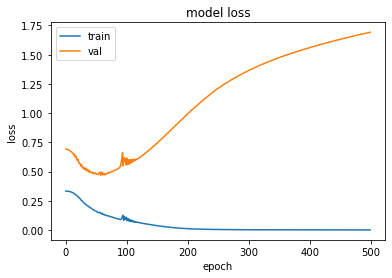

In [201]:
plot_loss(history)

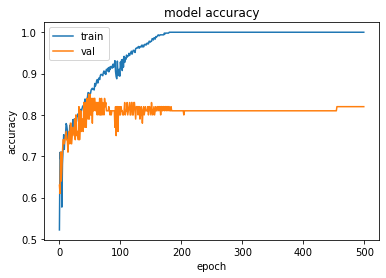

In [202]:
plot_accuracy(history)

In [203]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=75, learning_rate=0.001)

4/4 [==============================] - 0s 28ms/step - loss: 0.3336 - precision_71: 0.7826 - recall_71: 0.9000 - accuracy: 0.8600 - weighted_accuracy: 0.8600


In [204]:
print_report(precision_scores, recall_scores)

Speedup: 1.74992140039931 +- 0.044005058231909595
Precision: 0.728449821472168 +- 0.018962103056816327
Recall: 0.8399999976158142 +- 0.015165747429516508


## Just dense

In [256]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    #keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [257]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_125 (Flatten)        (None, 10000)             0         
_________________________________________________________________
dense_352 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_353 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_354 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


In [258]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=200, learning_rate=0.001)

Epoch 1/200
1/1 [==============================] - 0s 351ms/step - loss: 0.4356 - precision_107: 0.4918 - recall_107: 0.1875 - accuracy: 0.5975 - weighted_accuracy: 0.5292 - val_loss: 75.9260 - val_precision_107: 0.4000 - val_recall_107: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 2/200
1/1 [==============================] - 0s 96ms/step - loss: 30.0823 - precision_107: 0.4000 - recall_107: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 17.0443 - val_precision_107: 0.4000 - val_recall_107: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 75ms/step - loss: 6.7276 - precision_107: 0.4000 - recall_107: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 12.1219 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00 - val_accuracy: 0.6000 - val_weighted_accuracy: 0.6000
Epoch 4/200
1/1 [==============================] - 0s 57ms/step - loss: 7.3095 - precision_10

Epoch 28/200
1/1 [==============================] - 0s 65ms/step - loss: 0.2961 - precision_107: 0.5673 - recall_107: 0.7375 - accuracy: 0.6700 - weighted_accuracy: 0.6812 - val_loss: 1.7541 - val_precision_107: 0.4000 - val_recall_107: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 29/200
1/1 [==============================] - 0s 83ms/step - loss: 0.6801 - precision_107: 0.4000 - recall_107: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 1.4470 - val_precision_107: 0.4000 - val_recall_107: 1.0000 - val_accuracy: 0.4000 - val_weighted_accuracy: 0.4000
Epoch 30/200
1/1 [==============================] - 0s 59ms/step - loss: 0.5618 - precision_107: 0.4000 - recall_107: 1.0000 - accuracy: 0.4000 - weighted_accuracy: 0.5000 - val_loss: 0.6365 - val_precision_107: 0.2500 - val_recall_107: 0.0750 - val_accuracy: 0.5400 - val_weighted_accuracy: 0.5400
Epoch 31/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3281 - precision_107: 0.7037

1/1 [==============================] - 0s 73ms/step - loss: 0.2827 - precision_107: 0.5294 - recall_107: 0.8438 - accuracy: 0.6375 - weighted_accuracy: 0.6719 - val_loss: 0.5963 - val_precision_107: 0.6316 - val_recall_107: 0.6000 - val_accuracy: 0.7000 - val_weighted_accuracy: 0.7000
Epoch 56/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2769 - precision_107: 0.6667 - recall_107: 0.6250 - accuracy: 0.7250 - weighted_accuracy: 0.7083 - val_loss: 0.5957 - val_precision_107: 0.5806 - val_recall_107: 0.4500 - val_accuracy: 0.6500 - val_weighted_accuracy: 0.6500
Epoch 57/200
1/1 [==============================] - 0s 56ms/step - loss: 0.2873 - precision_107: 0.7069 - recall_107: 0.5125 - accuracy: 0.7200 - weighted_accuracy: 0.6854 - val_loss: 0.6200 - val_precision_107: 0.5800 - val_recall_107: 0.7250 - val_accuracy: 0.6800 - val_weighted_accuracy: 0.6800
Epoch 58/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2696 - precision_107: 0.6142 - recall_107

1/1 [==============================] - 0s 67ms/step - loss: 0.2549 - precision_107: 0.6098 - recall_107: 0.7812 - accuracy: 0.7125 - weighted_accuracy: 0.7240 - val_loss: 0.6129 - val_precision_107: 0.6154 - val_recall_107: 0.8000 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 83/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2534 - precision_107: 0.6321 - recall_107: 0.7625 - accuracy: 0.7275 - weighted_accuracy: 0.7333 - val_loss: 0.5985 - val_precision_107: 0.6364 - val_recall_107: 0.7000 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 84/200
1/1 [==============================] - 0s 67ms/step - loss: 0.2535 - precision_107: 0.6648 - recall_107: 0.7312 - accuracy: 0.7450 - weighted_accuracy: 0.7427 - val_loss: 0.6101 - val_precision_107: 0.6154 - val_recall_107: 0.8000 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 85/200
1/1 [==============================] - 0s 72ms/step - loss: 0.2520 - precision_107: 0.6440 - recall_107

1/1 [==============================] - 0s 68ms/step - loss: 0.2350 - precision_107: 0.6702 - recall_107: 0.7875 - accuracy: 0.7600 - weighted_accuracy: 0.7646 - val_loss: 0.5981 - val_precision_107: 0.6346 - val_recall_107: 0.8250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 110/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2342 - precision_107: 0.6813 - recall_107: 0.7750 - accuracy: 0.7650 - weighted_accuracy: 0.7667 - val_loss: 0.5983 - val_precision_107: 0.6346 - val_recall_107: 0.8250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 111/200
1/1 [==============================] - 0s 55ms/step - loss: 0.2335 - precision_107: 0.6831 - recall_107: 0.7812 - accuracy: 0.7675 - weighted_accuracy: 0.7698 - val_loss: 0.6036 - val_precision_107: 0.6296 - val_recall_107: 0.8500 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 112/200
1/1 [==============================] - 0s 65ms/step - loss: 0.2328 - precision_107: 0.6772 - recall_

1/1 [==============================] - 0s 61ms/step - loss: 0.2119 - precision_107: 0.7238 - recall_107: 0.8188 - accuracy: 0.8025 - weighted_accuracy: 0.8052 - val_loss: 0.6062 - val_precision_107: 0.6200 - val_recall_107: 0.7750 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 137/200
1/1 [==============================] - 0s 76ms/step - loss: 0.2109 - precision_107: 0.7263 - recall_107: 0.8125 - accuracy: 0.8025 - weighted_accuracy: 0.8042 - val_loss: 0.6094 - val_precision_107: 0.6275 - val_recall_107: 0.8000 - val_accuracy: 0.7300 - val_weighted_accuracy: 0.7300
Epoch 138/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2099 - precision_107: 0.7238 - recall_107: 0.8188 - accuracy: 0.8025 - weighted_accuracy: 0.8052 - val_loss: 0.6062 - val_precision_107: 0.6200 - val_recall_107: 0.7750 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 139/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2089 - precision_107: 0.7360 - recall_

1/1 [==============================] - 0s 65ms/step - loss: 0.2017 - precision_107: 0.8712 - recall_107: 0.7188 - accuracy: 0.8450 - weighted_accuracy: 0.8240 - val_loss: 0.7316 - val_precision_107: 0.5312 - val_recall_107: 0.8500 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 164/200
1/1 [==============================] - 0s 56ms/step - loss: 0.2066 - precision_107: 0.6181 - recall_107: 0.9812 - accuracy: 0.7500 - weighted_accuracy: 0.7885 - val_loss: 0.6281 - val_precision_107: 0.7000 - val_recall_107: 0.5250 - val_accuracy: 0.7200 - val_weighted_accuracy: 0.7200
Epoch 165/200
1/1 [==============================] - 0s 66ms/step - loss: 0.2070 - precision_107: 0.8880 - recall_107: 0.6938 - accuracy: 0.8425 - weighted_accuracy: 0.8177 - val_loss: 0.7197 - val_precision_107: 0.5246 - val_recall_107: 0.8000 - val_accuracy: 0.6300 - val_weighted_accuracy: 0.6300
Epoch 166/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2006 - precision_107: 0.6341 - recall_

1/1 [==============================] - 0s 76ms/step - loss: 0.2086 - precision_107: 0.5867 - recall_107: 0.9937 - accuracy: 0.7175 - weighted_accuracy: 0.7635 - val_loss: 0.7451 - val_precision_107: 0.6111 - val_recall_107: 0.2750 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 191/200
1/1 [==============================] - 0s 65ms/step - loss: 0.2389 - precision_107: 0.9620 - recall_107: 0.4750 - accuracy: 0.7825 - weighted_accuracy: 0.7312 - val_loss: 0.9878 - val_precision_107: 0.4568 - val_recall_107: 0.9250 - val_accuracy: 0.5300 - val_weighted_accuracy: 0.5300
Epoch 192/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2544 - precision_107: 0.5229 - recall_107: 1.0000 - accuracy: 0.6350 - weighted_accuracy: 0.6958 - val_loss: 0.7479 - val_precision_107: 0.6111 - val_recall_107: 0.2750 - val_accuracy: 0.6400 - val_weighted_accuracy: 0.6400
Epoch 193/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2382 - precision_107: 0.9615 - recall_

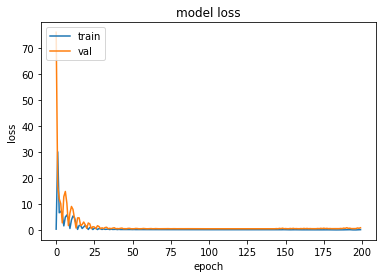

In [259]:
plot_loss(history)

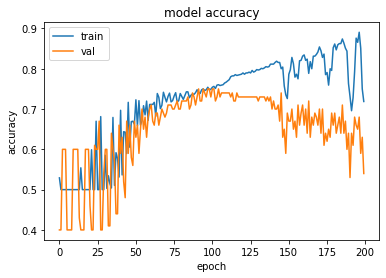

In [260]:
plot_accuracy(history)

In [262]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=100, learning_rate=0.001)

4/4 [==============================] - 0s 50ms/step - loss: 0.6198 - precision_114: 0.5918 - recall_114: 0.7250 - accuracy: 0.6900 - weighted_accuracy: 0.6900


In [263]:
print_report(precision_scores, recall_scores)

Speedup: 1.4301497522471291 +- 0.03214515967179856
Precision: 0.5993244171142578 +- 0.017198088946132825
Recall: 0.6550000071525574 +- 0.03834058194802871


## Fewer dense

In [212]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    #keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    #keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [213]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_95 (Flatten)         (None, 19208)             0         
_________________________________________________________________
dense_285 (Dense)            (None, 256)               4917504   
_________________________________________________________________
dense_286 (Dense)            (None, 1)                 257       
Total params: 4,917,761
Trainable params: 4,917,761
Non-trainable params: 0
_________________________________________________________________


In [214]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=200, learning_rate=0.001)

Epoch 1/200
1/1 [==============================] - 0s 380ms/step - loss: 0.3328 - precision_78: 0.3871 - recall_78: 0.9000 - accuracy: 0.3900 - weighted_accuracy: 0.4750 - val_loss: 0.6918 - val_precision_78: 0.5065 - val_recall_78: 0.9750 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6100
Epoch 2/200
1/1 [==============================] - 0s 84ms/step - loss: 0.3314 - precision_78: 0.5369 - recall_78: 1.0000 - accuracy: 0.6550 - weighted_accuracy: 0.7125 - val_loss: 0.6893 - val_precision_78: 0.5441 - val_recall_78: 0.9250 - val_accuracy: 0.6600 - val_weighted_accuracy: 0.6600
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 0.3296 - precision_78: 0.6235 - recall_78: 0.9937 - accuracy: 0.7575 - weighted_accuracy: 0.7969 - val_loss: 0.6858 - val_precision_78: 0.6167 - val_recall_78: 0.9250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 4/200
1/1 [==============================] - 0s 89ms/step - loss: 0.3271 - precision_78: 0.6488 - recall_78: 0.

Epoch 29/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2326 - precision_78: 0.7755 - recall_78: 0.9500 - accuracy: 0.8700 - weighted_accuracy: 0.8833 - val_loss: 0.5504 - val_precision_78: 0.6800 - val_recall_78: 0.8500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 30/200
1/1 [==============================] - 0s 65ms/step - loss: 0.2286 - precision_78: 0.7755 - recall_78: 0.9500 - accuracy: 0.8700 - weighted_accuracy: 0.8833 - val_loss: 0.5455 - val_precision_78: 0.6800 - val_recall_78: 0.8500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 31/200
1/1 [==============================] - 0s 67ms/step - loss: 0.2247 - precision_78: 0.7795 - recall_78: 0.9500 - accuracy: 0.8725 - weighted_accuracy: 0.8854 - val_loss: 0.5407 - val_precision_78: 0.6800 - val_recall_78: 0.8500 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.7800
Epoch 32/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2208 - precision_78: 0.7835 - recall_78:

Epoch 57/200
1/1 [==============================] - 0s 92ms/step - loss: 0.1418 - precision_78: 0.8315 - recall_78: 0.9563 - accuracy: 0.9050 - weighted_accuracy: 0.9135 - val_loss: 0.4536 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 58/200
1/1 [==============================] - 0s 73ms/step - loss: 0.1394 - precision_78: 0.8315 - recall_78: 0.9563 - accuracy: 0.9050 - weighted_accuracy: 0.9135 - val_loss: 0.4516 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 59/200
1/1 [==============================] - 0s 63ms/step - loss: 0.1370 - precision_78: 0.8315 - recall_78: 0.9563 - accuracy: 0.9050 - weighted_accuracy: 0.9135 - val_loss: 0.4497 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 60/200
1/1 [==============================] - 0s 70ms/step - loss: 0.1346 - precision_78: 0.8361 - recall_78:

Epoch 85/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0866 - precision_78: 0.8939 - recall_78: 1.0000 - accuracy: 0.9525 - weighted_accuracy: 0.9604 - val_loss: 0.4192 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 86/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0851 - precision_78: 0.8939 - recall_78: 1.0000 - accuracy: 0.9525 - weighted_accuracy: 0.9604 - val_loss: 0.4186 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 87/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0836 - precision_78: 0.8939 - recall_78: 1.0000 - accuracy: 0.9525 - weighted_accuracy: 0.9604 - val_loss: 0.4180 - val_precision_78: 0.7727 - val_recall_78: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 88/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0821 - precision_78: 0.8989 - recall_78:

Epoch 113/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0522 - precision_78: 0.9524 - recall_78: 1.0000 - accuracy: 0.9800 - weighted_accuracy: 0.9833 - val_loss: 0.4123 - val_precision_78: 0.7857 - val_recall_78: 0.8250 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 114/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0513 - precision_78: 0.9524 - recall_78: 1.0000 - accuracy: 0.9800 - weighted_accuracy: 0.9833 - val_loss: 0.4123 - val_precision_78: 0.7857 - val_recall_78: 0.8250 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 115/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0503 - precision_78: 0.9524 - recall_78: 1.0000 - accuracy: 0.9800 - weighted_accuracy: 0.9833 - val_loss: 0.4124 - val_precision_78: 0.7857 - val_recall_78: 0.8250 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 116/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0494 - precision_78: 0.9581 - recall

Epoch 141/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0318 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4177 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 142/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0313 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4180 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 143/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0308 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4183 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 144/200
1/1 [==============================] - 0s 85ms/step - loss: 0.0303 - precision_78: 1.0000 - recall

Epoch 169/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0203 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4279 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 170/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0200 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4283 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 171/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0197 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4287 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 172/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0194 - precision_78: 1.0000 - recall

Epoch 197/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0138 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4397 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 198/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0136 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4401 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 199/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0134 - precision_78: 1.0000 - recall_78: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4405 - val_precision_78: 0.7907 - val_recall_78: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 200/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0133 - precision_78: 1.0000 - recall

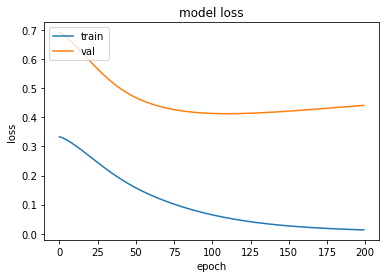

In [215]:
plot_loss(history)

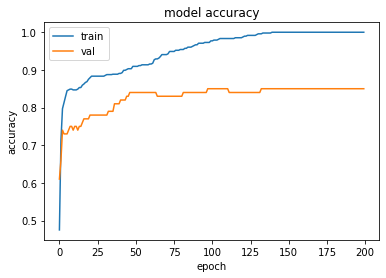

In [216]:
plot_accuracy(history)

In [217]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=100, learning_rate=0.001)

4/4 [==============================] - 0s 34ms/step - loss: 0.3179 - precision_83: 0.8222 - recall_83: 0.9250 - accuracy: 0.8900 - weighted_accuracy: 0.8900


In [218]:
print_report(precision_scores, recall_scores)

Speedup: 1.8196632326072788 +- 0.05273659034196043
Precision: 0.7613388895988464 +- 0.02127312993911954
Recall: 0.8200000047683715 +- 0.03420526533195974


In [219]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=50, learning_rate=0.001)

4/4 [==============================] - 0s 20ms/step - loss: 0.4063 - precision_88: 0.7872 - recall_88: 0.9250 - accuracy: 0.8700 - weighted_accuracy: 0.8700


In [220]:
print_report(precision_scores, recall_scores)

Speedup: 1.7403660690474567 +- 0.047708592859403674
Precision: 0.7229978322982789 +- 0.019872832162908062
Recall: 0.8600000023841858 +- 0.03209361292318606


In [221]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=75, learning_rate=0.001)

4/4 [==============================] - 0s 21ms/step - loss: 0.3493 - precision_93: 0.8043 - recall_93: 0.9250 - accuracy: 0.8800 - weighted_accuracy: 0.8800


In [222]:
print_report(precision_scores, recall_scores)

Speedup: 1.7524196664221552 +- 0.05221667503068932
Precision: 0.7309994459152221 +- 0.0211708047332194
Recall: 0.8200000047683715 +- 0.03563705581661255


In [223]:
## Bigger dense

In [225]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    #keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    #keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [226]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=200, learning_rate=0.001)

Epoch 1/200
1/1 [==============================] - 0s 414ms/step - loss: 0.3327 - precision_94: 0.3977 - recall_94: 0.6562 - accuracy: 0.4650 - weighted_accuracy: 0.4969 - val_loss: 0.6904 - val_precision_94: 0.5692 - val_recall_94: 0.9250 - val_accuracy: 0.6900 - val_weighted_accuracy: 0.6900
Epoch 2/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3307 - precision_94: 0.6148 - recall_94: 0.9875 - accuracy: 0.7475 - weighted_accuracy: 0.7875 - val_loss: 0.6867 - val_precision_94: 0.6167 - val_recall_94: 0.9250 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7400
Epoch 3/200
1/1 [==============================] - 0s 47ms/step - loss: 0.3280 - precision_94: 0.6488 - recall_94: 0.9812 - accuracy: 0.7800 - weighted_accuracy: 0.8135 - val_loss: 0.6814 - val_precision_94: 0.6271 - val_recall_94: 0.9250 - val_accuracy: 0.7500 - val_weighted_accuracy: 0.7500
Epoch 4/200
1/1 [==============================] - 0s 75ms/step - loss: 0.3245 - precision_94: 0.6783 - recall_94: 0.

Epoch 29/200
1/1 [==============================] - 0s 71ms/step - loss: 0.1773 - precision_94: 0.7947 - recall_94: 0.9438 - accuracy: 0.8800 - weighted_accuracy: 0.8906 - val_loss: 0.4722 - val_precision_94: 0.7556 - val_recall_94: 0.8500 - val_accuracy: 0.8300 - val_weighted_accuracy: 0.8300
Epoch 30/200
1/1 [==============================] - 0s 55ms/step - loss: 0.1723 - precision_94: 0.7989 - recall_94: 0.9438 - accuracy: 0.8825 - weighted_accuracy: 0.8927 - val_loss: 0.4671 - val_precision_94: 0.7727 - val_recall_94: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 31/200
1/1 [==============================] - 0s 71ms/step - loss: 0.1674 - precision_94: 0.7989 - recall_94: 0.9438 - accuracy: 0.8825 - weighted_accuracy: 0.8927 - val_loss: 0.4623 - val_precision_94: 0.7727 - val_recall_94: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 32/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1627 - precision_94: 0.8032 - recall_94:

Epoch 57/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0796 - precision_94: 0.8920 - recall_94: 0.9812 - accuracy: 0.9450 - weighted_accuracy: 0.9510 - val_loss: 0.4082 - val_precision_94: 0.7727 - val_recall_94: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 58/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0772 - precision_94: 0.8933 - recall_94: 0.9937 - accuracy: 0.9500 - weighted_accuracy: 0.9573 - val_loss: 0.4077 - val_precision_94: 0.7727 - val_recall_94: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 59/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0749 - precision_94: 0.8933 - recall_94: 0.9937 - accuracy: 0.9500 - weighted_accuracy: 0.9573 - val_loss: 0.4072 - val_precision_94: 0.7727 - val_recall_94: 0.8500 - val_accuracy: 0.8400 - val_weighted_accuracy: 0.8400
Epoch 60/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0726 - precision_94: 0.8933 - recall_94:

Epoch 85/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0328 - precision_94: 0.9877 - recall_94: 1.0000 - accuracy: 0.9950 - weighted_accuracy: 0.9958 - val_loss: 0.4139 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 86/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0318 - precision_94: 0.9938 - recall_94: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 0.4146 - val_precision_94: 0.7955 - val_recall_94: 0.8750 - val_accuracy: 0.8600 - val_weighted_accuracy: 0.8600
Epoch 87/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0308 - precision_94: 0.9938 - recall_94: 1.0000 - accuracy: 0.9975 - weighted_accuracy: 0.9979 - val_loss: 0.4153 - val_precision_94: 0.7955 - val_recall_94: 0.8750 - val_accuracy: 0.8600 - val_weighted_accuracy: 0.8600
Epoch 88/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0298 - precision_94: 0.9938 - recall_94:

Epoch 113/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0146 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4375 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 114/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0143 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4384 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 115/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0139 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4393 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 116/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0136 - precision_94: 1.0000 - recall

Epoch 141/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0079 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4610 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 142/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0078 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4618 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 143/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0076 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4626 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 144/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0075 - precision_94: 1.0000 - recall

Epoch 169/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0050 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4811 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 170/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0049 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4818 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 171/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0049 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4824 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 172/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0048 - precision_94: 1.0000 - recall

Epoch 197/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0035 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4981 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 198/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0035 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4987 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 199/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0034 - precision_94: 1.0000 - recall_94: 1.0000 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 0.4992 - val_precision_94: 0.7907 - val_recall_94: 0.8500 - val_accuracy: 0.8500 - val_weighted_accuracy: 0.8500
Epoch 200/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0034 - precision_94: 1.0000 - recall

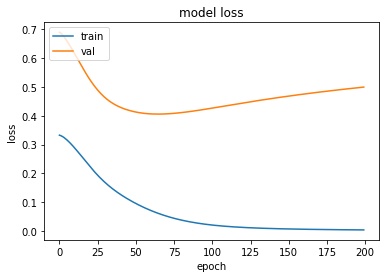

In [227]:
plot_loss(history)

In [228]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=60, learning_rate=0.001)

4/4 [==============================] - 0s 21ms/step - loss: 0.3101 - precision_99: 0.8222 - recall_99: 0.9250 - accuracy: 0.8900 - weighted_accuracy: 0.8900


In [229]:
print_report(precision_scores, recall_scores)

Speedup: 1.7787832418263396 +- 0.05733648949802816
Precision: 0.7440345764160157 +- 0.023317633106670628
Recall: 0.8050000071525574 +- 0.03701351278582033


In [230]:
## More bigger dense

In [231]:
def build_CNN_model():
    model =  keras.Sequential([
    keras.layers.Input(shape=X.shape[1:]),
    #keras.layers.Convolution2D(6, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(32, kernel_size=(5, 5), activation="relu"),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(24, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.Convolution2D(16, kernel_size=(3, 3), activation="relu", padding='valid'),
    #keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ##keras.layers.Convolution2D(64, kernel_size=(3, 3), activation="relu"),
    ##keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

In [234]:
modelCNN = build_CNN_model()
history = train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test, epochs=50, learning_rate=0.001)

Epoch 1/50
1/1 [==============================] - 0s 420ms/step - loss: 0.3327 - precision_101: 0.0000e+00 - recall_101: 0.0000e+00 - accuracy: 0.6000 - weighted_accuracy: 0.5000 - val_loss: 0.6911 - val_precision_101: 0.7949 - val_recall_101: 0.7750 - val_accuracy: 0.8300 - val_weighted_accuracy: 0.8300
Epoch 2/50
1/1 [==============================] - 0s 85ms/step - loss: 0.3315 - precision_101: 0.7889 - recall_101: 0.8875 - accuracy: 0.8600 - weighted_accuracy: 0.8646 - val_loss: 0.6874 - val_precision_101: 0.7273 - val_recall_101: 0.8000 - val_accuracy: 0.8000 - val_weighted_accuracy: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 68ms/step - loss: 0.3292 - precision_101: 0.7463 - recall_101: 0.9375 - accuracy: 0.8475 - weighted_accuracy: 0.8625 - val_loss: 0.6802 - val_precision_101: 0.7619 - val_recall_101: 0.8000 - val_accuracy: 0.8200 - val_weighted_accuracy: 0.8200
Epoch 4/50
1/1 [==============================] - 0s 176ms/step - loss: 0.3250 - precision_101: 0.77

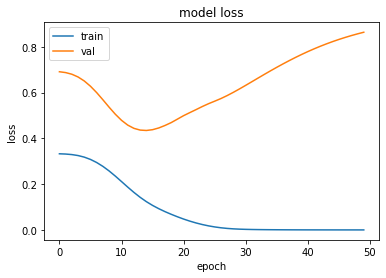

In [235]:
plot_loss(history)

In [236]:
precision_scores, recall_scores, results = cross_validate_cnn(epochs=15, learning_rate=0.001)

4/4 [==============================] - 0s 13ms/step - loss: 0.3124 - precision_106: 0.8222 - recall_106: 0.9250 - accuracy: 0.8900 - weighted_accuracy: 0.8900


In [237]:
print_report(precision_scores, recall_scores)

Speedup: 1.7837668321850622 +- 0.05197779205775528
Precision: 0.7458938360214233 +- 0.02134636649252755
Recall: 0.8100000143051147 +- 0.03209361329462812
